In [12]:
import sys,os
os.environ['pRT_input_data_path'] = '/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/input_data/'
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
import copy as cp
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns

from petitRADTRANS import Radtrans
from petitRADTRANS.retrieval.parameter import Parameter

from petitRADTRANS.retrieval.util import *
from petitRADTRANS.retrieval.chemistry import get_abundances
from petitRADTRANS.retrieval.models import  emission_model_diseq,\
                                            emission_model_diseq_simple_patchy_clouds,\
                                            interpolated_profile_emission,\
                                            guillot_emission,\
                                            gradient_profile_emission,\
                                            guillot_patchy_emission,\
                                            gradient_constrained
import petitRADTRANS.retrieval.plot_style as ps
from glob import glob
import scicomap as sc
matplotlib.rcParams['axes.linewidth'] = 2
import json
from molmass import Formula

version = "v03"
map_538 = sc.ScicoQualitative(cmap='538')
fixed_cmap_538 = map_538.get_mpl_color_map()
colour_dict = {"b":fixed_cmap_538(3/6),
              "c":fixed_cmap_538(2/6),
              "d":fixed_cmap_538(1/6),
              "e":fixed_cmap_538(0/6)}


model_function_dictionary = {}
model_function_dictionary["emission_model_diseq"] = emission_model_diseq
model_function_dictionary["emission_model_diseq_simple_patchy_clouds"] = emission_model_diseq_simple_patchy_clouds
model_function_dictionary["interpolated_profile_emission"] = interpolated_profile_emission
model_function_dictionary["guillot_emission"] = guillot_emission
model_function_dictionary["gradient_profile_emission"] = gradient_profile_emission
model_function_dictionary["guillot_patchy_emission"] = guillot_patchy_emission
model_function_dictionary["gradient_constrained"] = gradient_constrained


In [93]:
def c_to_o_from_abundances(samples):
    co = 10**samples["CO_all_iso_HITEMP"]
    h2o = 10**samples["H2O_Exomol"]
    h2 = 0.73 * (1.0-(co + h2o))
    he = 0.24 * (1.0-(co + h2o))
    abunds = {"CO_all_iso": co, "H2O": h2o, "H2": h2, "He":he}
    nfracs = mass_to_number(abunds)
    freeco = nfracs["CO_all_iso"]/(nfracs["CO_all_iso"]+ nfracs["H2O"])
    samples["C/O"] = freeco
    return 

def calculate_gravity_params(samples):
    gravity = -np.inf
    R_pl = -np.inf
    if 'log_g' in list(samples.columns) and 'mass' in list(samples.columns):
        gravity = 10**samples['log_g']
        R_pl = np.sqrt(nc.G*samples['mass']/gravity)
        samples["R_pl"] = R_pl
    elif 'log_g' in list(samples.columns):
        gravity= 10**samples['log_g']
        R_pl = samples['R_pl']
        samples["mass"] = gravity *R_pl**2 / nc.G
    elif 'mass' in list(samples.columns):
        R_pl = samples['R_pl']
        gravity = nc.G * samples['mass']/R_pl**2
        samples["log_g"] = np.log10(gravity)
    else:
        print("Pick two of log_g, R_pl and mass!")
    return

def calc_feh_from_abundances(samples, line_species):
    solar_nfracs = {}
    solar_nfracs['H'] = 0.9207539305712663
    solar_nfracs['He'] = 0.07836886940606574
    solar_nfracs['C'] = 0.0002478241000191816
    solar_nfracs['N'] = 6.225060569980629e-05
    solar_nfracs['O'] = 0.00045096580003490476
    solar_nfracs['Na'] = 1.6000869436558967e-06
    solar_nfracs['Mg'] = 3.665587420837336e-05
    solar_nfracs['Al'] = 2.5950000002008533e-06
    solar_nfracs['Si'] = 2.979500000230613e-05
    solar_nfracs['P'] = 2.3667020201598627e-07
    solar_nfracs['S'] = 1.2137900735543473e-05
    solar_nfracs['Cl'] = 2.911679585221254e-07
    solar_nfracs['K'] = 9.866056120020401e-08
    solar_nfracs['Ca'] = 2.0143901144484638e-06
    solar_nfracs['Ti'] = 8.206228044298752e-08
    solar_nfracs['V'] = 7.836886941506495e-09
    solar_nfracs['Fe'] = 2.911679585221254e-05
    solar_nfracs['Ni'] = 1.5280711681810828e-06


    """solar_mass_fracs = {}
    norm = 0.
    for species in solar_nfracs.keys():
        mass = Formula(species).mass
        solar_mass_fracs[species] = solar_nfracs[species]*mass
        norm += solar_nfracs[species]*mass

    for species in solar_nfracs.keys():
        solar_mass_fracs[species] = solar_mass_fracs[species]/norm"""

    mass_fractions = {}
    msum = 0
    for spec in line_species:
        mass_fractions[spec] = 10**samples[spec].to_numpy().flatten()
        msum += 10**samples[spec].to_numpy().flatten()
       
    if "H2" in list(samples.columns):
        mass_fractions["H2"] = 10**samples["H2"].to_numpy()
    else:
        mass_fractions["H2"] = 0.766 * (1.0-msum)
    if "He" in list(samples.columns):
        mass_fractions["He"] = 10**samples["He"].to_numpy()
    else:
        mass_fractions["He"] = 0.234 * (1.0-msum)
    n_fracs = mass_to_number(mass_fractions)

    atom_abunds = solar_nfracs['C'] + solar_nfracs['O']
    CNO_metals = n_fracs['H2O_Exomol']

    if 'CH4' in list(samples.columns):
        CNO_metals = CNO_metals + n_fracs['CH4'] 

    if 'NH3' in list(samples.columns):
        CNO_metals = CNO_metals +  n_fracs['NH3']
        atom_abunds = atom_abunds + solar_nfracs['N']

    if 'CO_all_iso_HITEMP' in list(samples.columns):
        CNO_metals = CNO_metals + n_fracs['CO_all_iso_HITEMP']

    if 'CO2' in list(samples.columns):
        CNO_metals = CNO_metals + (3* n_fracs['CO2'])

    if 'SO2' in list(samples.columns):
        CNO_metals = CNO_metals + (3* n_fracs['SO2'])
        atom_abunds = atom_abunds + solar_nfracs['S']

    metallicity = np.log10(CNO_metals/atom_abunds) 
    samples["Fe/H"] = metallicity
    return metallicity

def get_abundances_and_pbases(pRT_Object, samples, model_generating_function, params, name = ""):
    abundance_profiles = {} #Full mass fraction vertical profiles (nsample, nspecies, npressure)
    Pbases_all = {} # Cloud base pressures (nsample, ncloudspecies)
    Pbase_abundances = {} # Abundance at PBase (nsample, ncloudspecies)
    radius_profiles = {} #Full particle size profiles (nsample, ncloudspecies, npressure)
    Pbase_radius = {} # Particle radius at bottom of cloud (nsample, ncloudspecies)
    MMWs = []
    pressures = pRT_Object.press/1e6
    for cloud in pRT_Object.cloud_species:
        Pbases_all[cloud.split("_")[0]] = []
        Pbase_abundances[cloud.split("_")[0]] = []
    for line in pRT_Object.line_species:
        abundance_profiles[line] = []
    for ind,row in samples.iterrows():
        for key in params.keys():
            if key in samples.columns:
                params[key] = Parameter(key,False,value=row[key])
        try:
            pressure, temperatures = model_generating_function(pRT_Object,
                                                        params,
                                                        AMR = False,
                                                        PT_plot_mode = True)
        except KeyError:
            return
        try:                                            
            abundances, MMW, small_index, Pbases = get_abundances(pressure,
                                                                temperatures,
                                                                pRT_Object.line_species,
                                                                pRT_Object.cloud_species,
                                                                params,
                                                                AMR =False)
        except KeyError:
            return
        for key,val in abundances.items():
            if not key in abundance_profiles.keys():
                abundance_profiles[key] = []
            abundance_profiles[key].append(val)
        for key,val in Pbases.items():
            Pbases_all[key].append(val)
            Pbase_abundances[key].append(abundances[key][np.argmin(np.abs(pressures-val))])
        for i,cname in enumerate(pRT_Object.cloud_species):
            if not cname in radius_profiles.keys():
                radius_profiles[cname] = []
            if not cname in Pbase_radius.keys():
                Pbase_radius[cname] = []
            radius_profiles[cname].append(pRT_Object.r_g[:,i])
            Pbase_radius[cname].append(np.mean(pRT_Object.r_g[:,i]))
        MMWs.append(np.mean(MMW))
    np.savez(f"retrieval_output_arrays/{name}_particle_radii",radius_profiles)
    for key, val in Pbase_radius.items():
        samples[f"mean_particle_radius_{key}"] = val
    np.savez(f"retrieval_output_arrays/{name}_abundance_profiles",abundance_profiles)
    for key, val in Pbases_all.items():
        samples[f"log_Pbase_{key}"] = np.log10(val)
        samples[f"Pbase_{key}"] = val
        if f"eq_scaling_{key}" in list(samples.columns):
            samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
    MMWs = np.array(MMWs)
    samples["MMW"] = MMWs

def temp_at_Pquench(pRT_Object, sample, model_generating_function, params, name = ""):
    if not "log_pquench" in sample.columns:
        return
    pressures = pRT_Object.press/1e6
    temps = []
    for ind,row in sample.iterrows():
        for key in params.keys():
            if key in sample.columns:
                params[key] = Parameter(key,False,value=row[key])
        try:
            pressure, temperatures = model_generating_function(pRT_Object,
                                                               params,
                                                               AMR = False,
                                                               PT_plot_mode = True)
        except KeyError:
            return
        ind = np.argmin(np.abs(pressures - 10**row["log_pquench"]))
        temps.append(temperatures[ind])
    temps = np.array(temps)
    sample["quench_temperature"] = temps
    return temps

def pbase_from_log(sample):
    for key in list(sample.columns):
        if "Pbase" in key and "log" in key:
            cloud = key.split('_')[-1]
            sample[f"Pbase_{cloud}"] = 10**sample[key]
            
def sample_teff(pRT_Object, samples, model_generating_function, params, distance = 10.0*nc.pc, name = ""):
    r"""
    This function samples the outputs of a retrieval and computes Teff
    for each sample. For each sample, a model is computed at low resolution,
    and integrated to find the total radiant emittance, which is converted into
    a temperature using the stefan boltzmann law: $j^{\star} = \sigma T^{4}$.
    Teff itself is computed using util.calc_teff.

    Args:
        sample_dict : dict
            A dictionary, where each key is the name of a retrieval, and the values
            are the equal weighted samples.
        param_dict : dict
            A dictionary where each key is the name of a retrieval, and the values
            are the names of the free parameters associated with that retrieval.
        ret_names : Optional(list(string))
            A list of retrieval names, each should be included in the sample_dict.
            If left as none, it defaults to only using the current retrieval name.
        nsample : Optional(int)
            The number of times to compute Teff. If left empty, uses the "take_PTs_from"
            plot_kwarg. Recommended to use ~300 samples, probably more than is set in
            the kwarg!
        resolution : int
            The spectra resolution to compute the models at. Typically, this should be very
            low in order to enable rapid calculation.
    Returns:
        tdict : dict
            A dictionary with retrieval names for keys, and the values are the calculated
            values of Teff for each sample.
    """
    teffs = []
    #rands = np.random.randint(0, samples.shape[0], nsample)
    for ind,row in samples.iterrows():
        for key in list(samples.columns):
            params[key] = Parameter(key,False,value=row[key])
        wlen, model = model_generating_function(pRT_Object,
                                                params,
                                                False,
                                                False)

        tfit = teff_calc(wlen, model, params["D_pl"].value, params["R_pl"].value)
        teffs.append(tfit)
    teffs = np.array(teffs)
    samples["Teff"] = teffs
    np.save(f"retrieval_output_arrays/{name}_sampled_teff", np.array(teffs))

def read_parameter_dict(dir, ret, sumfile):
    data_start = False
    free_param_start = False
    fixed_param_start = False

    free_param_list = []
    fixed_param_dict = {}
    current_name = None
    with open(f"{dir}out_PMN/{ret}_params.json", 'r') as f:
        free_param_list = json.load(f)
    for i,line in enumerate(sumfile):
        if line.strip() == "":
            continue
        if line.strip() == "Data":
            data_start = True
            free_param_start = False
            fixed_param_start = False
            continue
        if "Multinest Outputs" in line:
            data_start = False
            continue
        if "Best Fit" in line:
            data_start = False
        if "Free Parameters" in line:
            free_param_start = True
            fixed_param_start = False
            continue
        if "Fixed Parameters" in line:
            fixed_param_start = True
            continue

        if free_param_start:
            continue

        if fixed_param_start:
            param, val = line.split("=")
            param = param.strip()
            if param == "nnodes":
                fixed_param_dict[param] = int(float(val.replace('\n',"").strip()))
                continue
            if param == "num_layer":
                fixed_param_dict[param] = int(float(val.replace('\n',"").strip()))
                continue
            if param == "N_layers":
                fixed_param_dict[param] = int(float(val.replace('\n',"").strip()))
                continue
            fixed_param_dict[param] = float(val.replace('\n',"").strip())
            continue
    param_out = {}
    for key,val in fixed_param_dict.items():
        param_out[key] = Parameter(key,False,value = val)
    for name in free_param_list:
        param_out[name] = Parameter(name,False,value = None)
    return param_out

def calc_lbol(sample):
    if "Teff" in list(sample.columns) and "R_pl" in list(sample.columns):
        lum_planet = (
            4.0
            * np.pi
            * (sample["R_pl"]) ** 2.0
            * nc.sigma
            * sample["Teff"] ** 4.0
            / nc.l_sun
        )
        sample["Lbol"] = np.log10(lum_planet)


def get_elemental_ratios(sample):
    if "H2O_Exomol" in sample.columns or "CO_all_iso_HITEMP" in sample.columns:
        solar_nfracs = {}
    solar_nfracs['H'] = 0.9207539305712663
    solar_nfracs['He'] = 0.07836886940606574
    solar_nfracs['C'] = 0.0002478241000191816
    solar_nfracs['N'] = 6.225060569980629e-05
    solar_nfracs['O'] = 0.00045096580003490476
    solar_nfracs['Na'] = 1.6000869436558967e-06
    solar_nfracs['Mg'] = 3.665587420837336e-05
    solar_nfracs['Al'] = 2.5950000002008533e-06
    solar_nfracs['Si'] = 2.979500000230613e-05
    solar_nfracs['P'] = 2.3667020201598627e-07
    solar_nfracs['S'] = 1.2137900735543473e-05
    solar_nfracs['Cl'] = 2.911679585221254e-07
    solar_nfracs['K'] = 9.866056120020401e-08
    solar_nfracs['Ca'] = 2.0143901144484638e-06
    solar_nfracs['Ti'] = 8.206228044298752e-08
    solar_nfracs['V'] = 7.836886941506495e-09
    solar_nfracs['Fe'] = 2.911679585221254e-05
    solar_nfracs['Ni'] = 1.5280711681810828e-06


    """solar_mass_fracs = {}
    norm = 0.
    for species in solar_nfracs.keys():
        mass = Formula(species).mass
        solar_mass_fracs[species] = solar_nfracs[species]*mass
        norm += solar_nfracs[species]*mass

    for species in solar_nfracs.keys():
        solar_mass_fracs[species] = solar_mass_fracs[species]/norm"""

    mass_fractions = {}
    msum = 0
    for spec in line_species:
        mass_fractions[spec] = 10**samples[spec].to_numpy().flatten()
        msum += 10**samples[spec].to_numpy().flatten()
       
    if "H2" in list(samples.columns):
        mass_fractions["H2"] = 10**samples["H2"].to_numpy()
    else:
        mass_fractions["H2"] = 0.766 * (1.0-msum)
    if "He" in list(samples.columns):
        mass_fractions["He"] = 10**samples["He"].to_numpy()
    else:
        mass_fractions["He"] = 0.234 * (1.0-msum)
    n_fracs = mass_to_number(mass_fractions)
    N_metals = 0
    S_metals = 0
    atom_abunds = solar_nfracs['C'] + solar_nfracs['O']
    O_metals = n_fracs['H2O_Exomol']
    O_metals = O_metals + n_fracs['CO_all_iso_HITEMP']
    C_metals = n_fracs['CO_all_iso_HITEMP']
    if 'CH4' in list(samples.columns):
        C_metals = C_metals + n_fracs['CH4'] 
    if 'NH3' in list(samples.columns):
        N_metals = N_metals + n_fracs['NH3']
    if 'HCN' in list(samples.columns):
        N_metals = N_metals +  n_fracs['NH3']
        C_metals = C_metals +  n_fracs['NH3']
    if 'H2S' in list(samples.columns):
        S_metals = S_metals +  n_fracs['NH3']            
    if 'CO2' in list(samples.columns):
        C_metals = C_metals + n_fracs['CO2']
        O_metals = O_metals + (2*n_fracs['CO2'])

    msum = 0
    for key,val in mass_fractions.items():
        msum+=val[0]
    H_mass = 0.766 * (1-msum)
    samples["Fe/H"] = metallicity

def timescale_1(Pquench, metallicity, temperature):
    t1 = 1.5e-6 * (1/Pquench) * metallicity**-0.7 * np.exp(42000.0/temperature)
    return t1

def timescale_2(Pquench, temperature):
    t2 = 40.0 * (Pquench**-2.0) * np.exp(25000.0/temperature)
    return t2

def scale_height(temperature, MMW, gravity):
    H = nc.kB * temperature / (MMW * gravity * 1.67e-24) # hydrogen mass
    return H

def calculate_kzz_from_pquench(sample):
    try:
        temperature = sample["Teff"]
    except KeyError:
        return
    gravity = 10**sample["log_g"]
    MMW = sample["MMW"]
    try:
        metallicity = 10**sample["Fe/H"]
    except KeyError:
        return
    try:
        Pquench = 10**sample["log_pquench"]
    except KeyError:
        return
        
    tCO = 1 / ((1/timescale_1(Pquench, metallicity, temperature)) + (1/timescale_2(Pquench, temperature)))
    H = scale_height(temperature, MMW, gravity)
    kzz = (H**2)/tCO
    sample["log10_kzz_chem"] = np.log10(kzz)
    return np.log10(kzz)




In [94]:
samples[list(samples.keys())[15]]["log_Pbase_MgSiO3(c)"]

0      -2.816404
1      -2.637346
2      -2.588208
3      -3.240173
4      -2.565823
          ...   
3578   -2.512087
3579   -2.707855
3580   -2.764262
3581   -2.651980
3582   -2.440963
Name: log_Pbase_MgSiO3(c), Length: 3583, dtype: float64

In [95]:
data_dir = "/Users/nasedkin/Documents/RetrievalResults/HR8799_2023_Retrievals/"
model_generating_function = emission_model_diseq
planets = ["b","c","d","e"]

samples = {}
max_evidence = {}
names = []

calc_teff = True
resolution = 40
line_species = ['H2O_Exomol', 
                'CO_all_iso_HITEMP', 
                'CH4', 
                'CO2', 
                'NH3', 
                'HCN',
                'H2S', 
                'FeH',
                'PH3', 
                'Na_allard', 
                'K_allard', 
                'TiO_all_Exomol', 
                'VO',
                'SiO']

ignore_ret_list = ["HR8799c_23_v01_diseq_all_grav_freeFeMgCloud_logg_fseds_newbins_newphot",
                   "HR8799e_23_v01_free_all_freeFeMgCloud_grad_newphot_newconv_newSPHGPI",
                   "HR8799d_23_v01_diseq_all_nosphfull_eqFeMgCloud",
                   "HR8799d_23_v01_diseq_all_nosphfull_eqFeMgCloud",
                   "HR8799c_23_v01_diseq_all_osbin_patchyeqFeMgCloud_logg_newbins_newphot",
                   "HR8799c_23_v03_free_nograv_os_freeFeMgCloud_guillot_newphot"
                   ]
for count,planet in enumerate(planets):
    full_list = sorted(glob(f"{data_dir}{planet}_full/out_PMN/*post_equal_weights*"))
    free_list = sorted(glob(f"{data_dir}{planet}_free/out_PMN/*post_equal_weights*"))
    max_evidence[planet] = -np.inf
    for f in full_list:
        short = f.split("_post_equal_weights")[0]
        name = short.split("/")[-1]
        if name in ignore_ret_list: continue
        print(name)
        try:
            pars = json.load(open(short+'_params.json'))
        except ValueError as error:
            print(error)
        pars.append("log_likelihood")
        sample = pd.read_csv(f, delim_whitespace=True,names=pars)
        if sample.shape[0] < 100:
            print("Need more than 100 sample in post equal weights!")
            continue
        names.append(name)
        # Setup the pRT object
        resolution = 40
        

        continuum_opacities = ['H2-H2', 'H2-He']  
        rayleigh_species = ['H2', 'He']  

        species = []
        for spec in line_species:
            species.append(spec + "_R_" + str(resolution))
        
        summary_filename = f"{data_dir}{planet}_full/evaluate_{name}/{name}_ret_summary.txt" 
        if not os.path.exists(summary_filename):continue
        sumfile = list(open(summary_filename))
        sample.log10_baysian_evidence = -np.inf
        sample.chi2_DoF = -np.inf
        if os.path.exists(summary_filename):
            for s in sumfile:
                if "log Z" in s:
                    evidence = float(s.split("=")[-1].split("+")[0].strip())
                    if evidence > max_evidence[planet]:
                        max_evidence[planet] = evidence
                    sample.log10_baysian_evidence = evidence
                if "DoF =" in s:
                    chi2 = float(s.split("=")[-1].strip())
                    sample.chi2_DoF = chi2
        if os.path.exists(f"retrieval_output_arrays/{name}_sampled_teff.npy"):
                teff = np.load(f"retrieval_output_arrays/{name}_sampled_teff.npy")
                sample["Teff"] = teff
        elif os.path.exists(f"{data_dir}{planet}_full/evaluate_{name}/sampled_teff.npy"):
            teff = np.load(f"{data_dir}{planet}_full/evaluate_{name}/sampled_teff.npy")
            sample["Teff"] = np.pad(teff,
                                    (0,int(sample.shape[0]-teff.shape[0])),
                                    constant_values = (np.nan,np.nan))
        if calc_teff:
            for s in sumfile:
                if "Model Function" in s:
                    model_generating_function = model_function_dictionary[s.split("=")[-1].strip()]
                    break
            parameters_base = read_parameter_dict(f"{data_dir}{planet}_full/",name,sumfile)  
            cloud_species = []
            for key in list(sample.columns):
                if "(c)" in key:
                    cname = key.split('_')[-1] + "_cd"
                    if not cname in cloud_species:
                        cloud_species.append(cname)
                        
            pressures = np.logspace(-6,3,80)
            prt_object = Radtrans(line_species=cp.copy(species),
                                    rayleigh_species=cp.copy(rayleigh_species),
                                    continuum_opacities=cp.copy(continuum_opacities),
                                    cloud_species=cp.copy(cloud_species),
                                    mode='c-k',
                                    wlen_bords_micron=[0.8, 2],
                                    do_scat_emis=True)
            prt_object.setup_opa_structure(pressures)
            #sample_teff(prt_object, sample, model_generating_function, parameters_base, distance = 10.0*nc.pc, name = name)
            get_abundances_and_pbases(prt_object, sample, model_generating_function, parameters_base, name = name)
            temp_at_Pquench(prt_object, sample, model_generating_function, parameters_base, name = name)
        calc_lbol(sample)
        calculate_gravity_params(sample)
        calculate_kzz_from_pquench(sample)
        samples[name] = sample
    for f in free_list:
        short = f.split("_post_equal_weights")[0]
        name = short.split("/")[-1]
        if name in ignore_ret_list: continue
        print(name)
        try:
            pars = json.load(open(short+'_params.json'))
        except ValueError as error:
            print(error)
        pars.append("log_likelihood")

        sample = pd.read_csv(f, delim_whitespace=True,names=pars)
        if sample.shape[0] < 100:
            print("Need more than 100 sample in post equal weights!")
            continue
        if planet =="b" and not "correctos" in name:
            continue
        c_to_o_from_abundances(sample)
        calculate_gravity_params(sample)
        pbase_from_log(sample)
        atmo_species = []
        for key in list(sample.columns):
            if key in line_species:
                atmo_species.append(key)  
        summary_filename = f"{data_dir}{planet}_free/evaluate_{name}/{name}_ret_summary.txt" 
        sumfile = list(open(summary_filename))
        sample.log10_baysian_evidence = -np.inf
        sample.chi2_DoF = -np.inf

        if os.path.exists(summary_filename):
            for s in sumfile:
                if "log Z" in s:
                    evidence = float(s.split("=")[-1].split("+")[0].strip())
                    if evidence > max_evidence[planet]:
                        max_evidence[planet] = evidence
                    sample.log10_baysian_evidence = evidence           
                if "𝛘^2/DoF" in s:
                    chi2 = float(s.split("=")[-1].split("+")[0].strip())
                    sample.chi2_DoF = chi2
        if os.path.exists(f"retrieval_output_arrays/{name}_sampled_teff.npy"):
            teff = np.load(f"retrieval_output_arrays/{name}_sampled_teff.npy")
            sample["Teff"] = teff
        elif os.path.exists(f"{data_dir}{planet}_free/evaluate_{name}/sampled_teff.npy"):
            teff = np.load(f"{data_dir}{planet}_free/evaluate_{name}/sampled_teff.npy")
            if sample.shape[0] >teff.shape[0]:
                sample["Teff"] = np.pad(teff,
                                        (0,int(sample.shape[0]-teff.shape[0])),
                                        constant_values = (np.nan,np.nan))  
            else:   
                sample["Teff"] = teff[:sample.shape[0]]
        if calc_teff:
            parameters_base = read_parameter_dict(f"{data_dir}{planet}_free/",name,sumfile)       

            for s in sumfile:
                if "Model Function" in s:
                    model_generating_function = model_function_dictionary[s.split("=")[-1].strip()]
                    break
                
            cloud_species = []
            species = []
            for key in list(sample.columns):
                if "(c)" in key:
                    cname = key.split('_')[-1] + "_cd"
                    if not cname in cloud_species:
                        cloud_species.append(cname)
                if key in line_species:
                    species.append(key + "_R_" + str(resolution))
            pressures = np.logspace(-6,3,800)
            prt_object = Radtrans(line_species=cp.copy(species),
                                    rayleigh_species=cp.copy(rayleigh_species),
                                    continuum_opacities=cp.copy(continuum_opacities),
                                    cloud_species=cp.copy(cloud_species),
                                    mode='c-k',
                                    wlen_bords_micron=[0.8, 2],
                                    do_scat_emis=True)
            prt_object.setup_opa_structure(pressures)
            #sample_teff(prt_object, sample, model_generating_function, parameters_base, distance = 10.0*nc.pc, name = name)
            get_abundances_and_pbases(prt_object, sample, model_generating_function, parameters_base, name = name)
        calc_lbol(sample)
        calc_feh_from_abundances(sample, atmo_species)

        names.append(name)
        samples[name] = sample
     


HR8799b_23_v02_diseq_all_scaleos_clear


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v02_diseq_all_scaleos_eqFeCloud
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799b_23_v02_diseq_all_scaleos_eqFeMgCloud_mrprior_newdata_newphot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799b_23_v02_diseq_all_scaleos_eqFeMgCloud_mrprior
Need more than 100 sample in post equal weights!
HR8799b_23_v02_diseq_all_scaleos_eqFeMgCloud


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799b_23_v02_diseq_all_scaleos_eqKCLCloud_mrprior_newdata_newphot
Need more than 100 sample in post equal weights!
HR8799b_23_v02_diseq_all_scaleos_eqMgCloud
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799b_23_v02_diseq_all_scaleos_eqNa2SCloud_mrprior_newdata_newphot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Na2S ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799b_23_v02_diseq_all_scaleos_freeFeMgCloud_mrprior_newdata_newphot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_highfeh_fseds


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_highfeh_grad_fseds
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_highfeh_spline_fseds
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_newdata_newphot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799b_23_v04_diseq_all_scaleos_eqMgFeCloudPatchy_mrprior_highfeh_fseds


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799b_23_v04_diseq_all_scaleos_eqMgFeCloud_grad_mrprior_highfeh_fseds
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799b_23_v04_diseq_all_scaleos_eqMgamFeCloud_mrprior_highfeh_fseds


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799b_23_v04_diseq_all_scaleos_eqNa2SCloud_mrprior_highfeh_fseds


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Na2S ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v04_diseq_all_scaleos_freeMgFeCloud_grad_mrprior_highfeh_fseds
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_clear_0nodes_v2
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_clear_1nodes_v2
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_clear_2nodes_v2
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_clear_3nodes_v2
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_clear_4nodes_v2
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_clear_5nodes_v2
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_clear_6nodes_v2


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_clear_7nodes_v2


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_eqMgCloud_0nodes_v6
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_eqMgCloud_1nodes_v6
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_eqMgCloud_2nodes_v6
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_eqMgCloud_3nodes_v6
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_eqMgCloud_4nodes_v6
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_eqMgCloud_5nodes_v6
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_eqMgCloud_6nodes_v6
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_eqMgCloud_7nodes_v6
Need more than 100 sample in post equal weights!
HR8799b_23_v01_free_all_correctos_freeMgCloud_0nodes_v4
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_freeMgCloud_0nodes_v5
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_freeMgCloud_1nodes_v5
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_freeMgCloud_2nodes_v4


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_freeMgCloud_2nodes_v5
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_freeMgCloud_3nodes_v4


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_freeMgCloud_3nodes_v5
Need more than 100 sample in post equal weights!
HR8799b_23_v01_free_all_correctos_freeMgCloud_4nodes_v5
Need more than 100 sample in post equal weights!
HR8799b_23_v01_free_all_correctos_freeMgCloud_guillot_newphot_mrprior
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_freeMgCloud_guillot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_freeMgcloud_1nodes_v3


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_correctos_freeMgcloud_1nodes_v4


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v01_free_all_scaleos_clear_0nodes
HR8799b_23_v01_free_all_scaleos_clear_1nodes
HR8799b_23_v01_free_all_scaleos_clear_2nodes
HR8799b_23_v01_free_all_scaleos_clear_3nodes
HR8799b_23_v01_free_all_scaleos_clear_4nodes
HR8799b_23_v01_free_all_scaleos_clear_5nodes
HR8799b_23_v01_free_all_scaleos_clear_6nodes
HR8799b_23_v01_free_all_scaleos_clear_7nodes
HR8799b_23_v01_free_all_scaleos_clear_8nodes
HR8799b_23_v01_free_all_scaleos_freeMgcloud_0nodes
HR8799b_23_v01_free_all_scaleos_freeMgcloud_0nodes_v2
HR879

/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v03_free_all_correctos_freeMgamCloud_newphotv2_mrprior
Need more than 100 sample in post equal weights!
HR8799b_23_v03_free_all_correctos_freeSiO2Cloud_newphotv2_mrprior


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.

  Read in opacity of cloud species SiO2-Lx ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v04_free_all_correctos_freeConstMassFeMgCloud_grad_newphotv2_mrprior


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799b_23_v04_free_all_correctos_freeFeMgCloud_grad_newphotv2_mrprior
Need more than 100 sample in post equal weights!
HR8799c_23_v01_diseq_all_grav_eqFeMgCloud_logg_fseds_newbins_newphot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799c_23_v01_diseq_all_grav_eqFeMgamPatchyCloud_mr_fseds_newbins_newphot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799c_23_v01_diseq_all_grav_freeFeMgCloud_mr_fseds_newbins_newphot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v01_diseq_all_noos_eqFeMgCloud_logg
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799c_23_v01_diseq_all_noos_patchyeqFeMgCloud_logg_newbins_newphot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799c_23_v01_diseq_nogpi_noos_eqFeMgCloud
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799c_23_v01_diseq_onlygrav_noos_clear_logg
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v01_diseq_onlygrav_noos_clear
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v01_diseq_onlygrav_noos_eqFeCloud
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799c_23_v01_diseq_onlygrav_noos_eqFeMgCloud
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799c_23_v01_diseq_onlygrav_noos_eqMgCloud_logg
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799c_23_v01_diseq_onlygrav_noos_eqMgCloud
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799c_23_v01_diseq_onlygravphot_noos_clear_logg
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v01_diseq_onlygravphot_noos_clear
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v01_diseq_onlygravphot_noos_eqFeCloud
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud_logg
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud_mrprior
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799c_23_v03_free_all_all_noos_freeFeMgCloud_guillot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v03_free_all_all_noos_freeMgCloud_guillot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v03_free_all_onlygrav_nogpi_clear_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v03_free_all_onlygrav_nogpi_eqMgCloud_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v03_free_all_onlygrav_nogpi_freeMgCloud_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v03_free_all_onlygrav_withphot_nogpi_clear_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v03_free_all_onlygravphot_nogpi_freeFeCloud_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v03_free_all_onlygravphot_nogpi_freeFeMgCloud_guillot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v03_free_all_onlygravphot_nogpi_freeMgCloud_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v03_free_all_osphot_nogpi_clear_guillot
Need more than 100 sample in post equal weights!
HR8799c_23_v03_free_grav_noos_freeFeMgCloud_guillot_newphot_newGPI_fseds_mr
Need more than 100 sample in post equal weights!
HR8799c_23_v04_free_grav_noos_freeFeMg2Cloud_guillot_newphot_newGPI_fseds_mr
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species Mg2SiO4 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v04_free_grav_noos_freeFeMgCloud_grad_newphot_newGPI_fseds_mr
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v04_free_grav_noos_freeFeMgCloud_guillot_newphot_newGPI_fseds_mr
Need more than 100 sample in post equal weights!
HR8799c_23_v04_free_grav_noos_freeFeMgCloud_spline_newphot_newGPI_fseds_mr


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v04_free_grav_noos_freeFeMgamCloud_guillot_newphot_newGPI_fseds_mr
Need more than 100 sample in post equal weights!
HR8799c_23_v04_free_grav_noos_freeMgCloud_guillot_newphot_newGPI_fseds_mr


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799c_23_v05_free_grav_noos_eqFeMgCloud_grad_newphot_newGPI_fseds_mr
Need more than 100 sample in post equal weights!
HR8799c_23_v06_free_grav_noos_freeFeMgCloud_guillot_allspecies
Need more than 100 sample in post equal weights!
HR8799d_23_v01_diseq_all_eqFeMgCloud_fseds_newconv_newphot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v01_diseq_all_noales_eqFeMgCloud_newconv
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v01_diseq_all_nocharis_eqFeMgCloud_newconv_newphot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v01_diseq_all_nogpi_eqFeMgCloud_newconv
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v01_diseq_all_nograv_eqFeMgCloud_newconv
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v01_diseq_all_nosph_eqFeMgCloud
HR8799d_23_v01_diseq_all_shortsph_eqFeMgCloud


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v01_diseq_onlygrav_clear
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799d_23_v01_diseq_onlygravphot_eqFeCloud
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v01_diseq_onlygravphot_eqFeMgCloud_mrprior


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v01_diseq_onlygravphot_eqFeMgCloud


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v01_diseq_onlygravphot_eqMgCloud
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v02_diseq_all_eqFeMg2Cloud_fseds_newconv_newphot_newSPHGPI_kzztintwide


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Mg2SiO4 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_newphot_newSPHGPI_grad


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_newphot_newSPHGPI_patchy


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_newphot_newSPHGPI
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_newphot_newSPHGPI_spline
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_noSPH_newGPI_kzztintwide
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v02_diseq_all_eqFeMgamCloud_fseds_newconv_newphot_newSPHGPI_tintwide
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799d_23_v03_free_onlygrav_clear_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799d_23_v03_free_onlygravphot_clear_free_MgCloud_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799d_23_v03_free_onlygravphot_clear_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799d_23_v04_free_all_eqFeMgCloud_guillot_fseds
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799d_23_v04_free_all_freeFeMgCloud_guillot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799d_23_v04_free_all_freeMgCloud_guillot
Need more than 100 sample in post equal weights!
HR8799d_23_v04_free_all_freeMgFeCloud_spline_scaleALES_newSPHGPI


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799d_23_v04_free_onlygravphot_free_MgCloud_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799d_23_v05_free_all_freeFeMg2Cloud_guillot_scaleALES_newSPHGPI


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.

  Read in opacity of cloud species Mg2SiO4 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799d_23_v05_free_all_freeFeMgamCloud_guillot_scaleALES_newSPHGPI


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799d_23_v05_free_all_freeMgFeCloud_eqbase_scaleALES_newSPHGPI


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799d_23_v05_free_all_freeMgFeCloud_grad_scaleALES_newSPHGPI
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799d_23_v05_free_all_freeMgFeCloud_guillot_scaleALES_newSPHGPI_FeH
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799d_23_v05_free_all_freeMgFeCloud_guillot_scaleALES_newSPHGPI


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799d_23_v06_free_all_eqMgFeCloud_grad_scaleALES_newSPHGPI
Need more than 100 sample in post equal weights!
HR8799e_23_v01_diseq_all_eqFeMgCloud_bothfseds_newphot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_diseq_all_eqFeMgCloud_bothfseds


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_diseq_all_eqFeMgCloud_grad_newphot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_diseq_all_eqFeMgCloud_hansen_newphot
Need more than 100 sample in post equal weights!
HR8799e_23_v01_diseq_all_eqFeMgCloud_mrprior


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_diseq_all_eqFeMgCloud_newphot_newSPH_fseds_mrprior
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_diseq_all_eqFeMgCloud_patchy_newphot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_diseq_all_eqFeMgCloud
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_diseq_all_eqFeMgCloud_spline_newphot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_diseq_nocharis_eqFeMgCloud_bothfseds


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_diseq_nogpi_eqFeMgCloud_bothfseds


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_diseq_nograv_eqFeMgCloud_bothfseds
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_diseq_nosph_eqFeMgCloud_bothfseds
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_diseq_onlygrav_clear
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v01_diseq_onlygrav_eqMgCloud
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_diseq_onlygravphot_clear
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v01_diseq_onlygravphot_eqMgCloud_mrprior
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_diseq_onlygravphot_eqMgCloud
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_logg


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_fixedfeh05
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_fixedfeh0


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_fixedfeh10


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_fixedfeh15
Need more than 100 sample in post equal weights!
HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_hansen


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_hansencd_widefeh


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v02_diseq_all_eqFeMgamCloud_newphot_newSPHGPI_mrprior_grad_fseds


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v03_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_fixedfeh15


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v03_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_hansencd_widefeh


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.
  Read line opacities of FeH_R_40...
 Done.
  Read line opacities of PH3_R_40...
 Done.
  Read line opacities of Na_allard_R_40...
 Done.
  Read line opacities of K_allard_R_40...
 Done.
  Read line opacities of TiO_all_Exomol_R_40...
 Done.
  Read line opacities of VO_R_40...
 Done.
  Read line opacities of SiO_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/335824816.py:159: RuntimeWarning: divide by zero encountered in log10
  samples[f"log_X_cb_{key}"] = np.log10(Pbase_abundances[key])


HR8799e_23_v01_free_all_clear_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v01_free_all_freeAl2Cloud_guillot_newphot_newconv


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species Al2O3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v01_free_all_freeFeMgCloud_guillot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v01_free_all_freeFeMgCloud_guillotfseds_newphot_newconv


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v01_free_all_freeFeMgCloud_guillotpatchy_newphot_newconv


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v01_free_all_freeFeMgCloud_spline_newphot_newconv


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species Fe ...
  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v01_free_all_freeMg2Cloud_guillot_newphot_newconv


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species Mg2SiO4 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v01_free_all_freeMgCloud_guillot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v01_free_all_freeSiCCloud_guillot_newphot_newconv
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species SiC ...
  Read CIA opacities for H2-H2...
 Done.

  Read CIA opacities for H2-He...
Done.

HR8799e_23_v01_free_gravphot_freeMgCloud_guillot_mrsigmaprior


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v02_free_all_eqFeMgCloud_grad_fseds_newphot_newconv_newSPHGPI


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v02_free_all_freeFeMgCloud_grad_fseds_newphot_newconv_newSPHGPI


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v02_free_all_freeFeMgCloud_guillot_newphot_newconv_newSPHGPI


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v02_free_all_freeFeMgCloud_guillotpatchy_newphot_newconv_newSPHGPI
Need more than 100 sample in post equal weights!
HR8799e_23_v02_free_all_freeMgCloud_guillot_newphot_newconv_newSPHGPI


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v03_free_onlygrav_clear_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v03_free_onlygrav_freeMgCloud_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v03_free_onlygravphot_clear_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v03_free_onlygravphot_freeFeCloud_guillot
Emission scattering is enabled: enforcing test_ck_shuffle_comp = True


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v03_free_onlygravphot_freeMgCloud_guillot_mrprior


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v03_free_onlygravphot_freeMgCloud_guillot


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

HR8799e_23_v04_free_all_freeFeMgCloud_guillotpatchy2_newphot_newconv_newSPHGPI


/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_Exomol_R_40...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_40...
 Done.
  Read line opacities of CH4_R_40...
 Done.
  Read line opacities of CO2_R_40...
 Done.
  Read line opacities of HCN_R_40...
 Done.
  Read line opacities of NH3_R_40...
 Done.
  Read line opacities of H2S_R_40...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



In [96]:
max_evidence

{'b': 4372.8, 'c': 5811.9, 'd': 5785.8, 'e': 5764.6}

In [97]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def make_violin_plot(sample_dict, 
                     retrieval_list, 
                     parameter, 
                     facecolour = 'tab:blue', 
                     labels = None, 
                     xlabel = None, 
                     planet = "",
                     tag = "",
                     normalize = 1,
                     vline = None):
    fig, ax = plt.subplots(figsize = (4,16))
    data = []
    label_dict = {}
    label_dict["C/O"] = "C/O"
    label_dict["Fe/H"] = "[M/H]"
    label_dict["H2O_Exomol"] = "Water Mass Fraction"
    label_dict["CO_all_iso_HITEMP"] = "CO Mass Fraction"
    label_dict["CH4"] = "CH4"
    label_dict["log_g"] = r"$\log g$ [cgs]"
    label_dict["R_pl"] = r"Radius [R$_{\rm Jup}$]"
    label_dict["mass"] = r"Mass [M$_{\rm Jup}$]"
    label_dict["Teff"] = r"T$_{\rm Eff}$ [K]"

    param_borders = {}
    param_borders["Fe/H"] = (-0.65,2.55)
    param_borders["C/O"] = (-0.1,1.1)
    param_borders["R_pl"] = (0.55,1.5)
    param_borders["log_g"] = (2,6)
    param_borders["Teff"] = (450,2050)
    if planet != "":
        facecolour=colour_dict[planet], 

    labels_use = []
    for i,name in enumerate(retrieval_list):
        if name in sample_dict.keys():
            if parameter in sample_dict[name].columns:
                dtemp = sample_dict[name][parameter].to_numpy()
                nans = np.isnan(dtemp)
                data.append(dtemp[~nans]/normalize)
                if labels is not None:
                    labels_use.append(labels[name])
                else:
                    labels_use.append(name)
        else:
            continue

    if len(data) == 0:
        print("No data to plot! Did you input a valid parameter? {parameter}")
        return
    parts = ax.violinplot(data, 
                          points = 1000,
                          showmedians=False,
                          vert=False,
                          widths = 0.8,
                          showextrema=False)
                          #positions = posns)

    colouruse_low = (facecolour[0][0],facecolour[0][1],facecolour[0][2],0.7)
    colouruse_high = (facecolour[0][0],facecolour[0][1],facecolour[0][2],1.0)
    for pc in parts['bodies']:
        pc.set_facecolor(colouruse_low)
        pc.set_edgecolor(colouruse_high)
        pc.set_linewidth(3)
        pc.set_alpha(0.9)
    #parts['cmedians'].set_color(facecolour)
    #parts['cquantiles'].set_color('w')

    quantile1, medians, quantile3 = [],[],[]
    for d in data:
        q1, m, q3 = np.quantile(d, [0.159, 0.50, 0.841])
        quantile1.append(q1)
        medians.append(m)
        quantile3.append(q3)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quantile1, quantile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
    inds = np.arange(1, len(medians) + 1)
    ax.hlines(inds, quantile1, quantile3, color='w', linestyle='-', lw=3)
    ax.scatter(medians,inds,marker = 'o', color = facecolour, edgecolors='w',linewidths=2,s=24,zorder = 50)

    if vline is not None:
        ax.axvline(vline,-1,inds[-1]+3, color = 'darkgray',linestyle = '--', linewidth = 4,zorder = 0)
        ax.set_ylim(0,inds[-1]+1)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    elif parameter in label_dict.keys():
        ax.set_xlabel(label_dict[parameter])
    else:
        ax.set_xlabel(parameter)
    if parameter in param_borders.keys():
        ax.set_xlim(param_borders[parameter])
        
    #ax.yaxis.tick_right()    
    ax.tick_params(axis="y",direction="in", pad = -62)
    ax.set_yticks(inds+0.2)
    ax.set_yticklabels(labels_use,  fontsize = 16)
    #ax.set_xlabel("Varying Models + Data Inclusion")
    plt.savefig(f"plots/HR8799{planet}_{parameter.replace('/','_')}_violinplot_{tag}_{version}.pdf",bbox_inches='tight')

In [160]:
# These are retrievals that actually failed, probably set bad parameters or didn't converge at all
failed_retrievals = ['HR8799b_23_v01_free_all_correctos_freeMgCloud_0nodes_v4',# Bad R_pl #Bad PBase
                    'HR8799b_23_v01_free_all_correctos_freeMgcloud_1nodes_v4',#Bad PBase
                    'HR8799b_23_v01_free_all_correctos_freeMgCloud_2nodes_v4', # Bad R_pl#Bad PBase
                    'HR8799b_23_v01_free_all_correctos_freeMgCloud_3nodes_v4',#Bad PBase
                    'HR8799c_23_v03_free_all_onlygrav_nogpi_freeMgCloud_guillot', # Bad Pbase
                    'HR8799c_23_v03_free_all_onlygravphot_nogpi_freeFeMgCloud_guillot', # Bad Pbase
                    'HR8799d_23_v03_free_onlygravphot_clear_free_MgCloud_guillot',#Bad PBase
                    'HR8799e_23_v03_free_onlygrav_freeMgCloud_guillot', # Bad PBase
                    'HR8799e_23_v03_free_onlygravphot_freeMgCloud_guillot_mrprior', # Bad PBase
                    'HR8799e_23_v03_free_onlygravphot_freeMgCloud_guillot',# Bad PBase
                    'HR8799e_23_v01_free_all_freeMgCloud_guillot',# Bad PBase
                    'HR8799e_23_v01_free_gravphot_freeMgCloud_guillot_mrsigmaprior',# Bad PBase
                    'HR8799e_23_v01_free_all_freeFeMgCloud_guillot', # Bad PBase
                    'HR8799e_23_v01_free_all_freeFeMgCloud_guillotfseds_newphot_newconv', # Bad PBase
                    'HR8799e_23_v01_free_all_freeFeMgCloud_guillotpatchy_newphot_newconv', # Bad PBase
                    'HR8799e_23_v03_free_onlygravphot_freeFeCloud_guillot',
                    'HR8799c_23_v03_free_all_onlygravphot_nogpi_freeFeMgCloud_guillot',# Bad Pbase
                    'HR8799c_23_v03_free_all_onlygrav_nogpi_freeMgCloud_guillot',
                    'HR8799c_23_v01_diseq_nogpi_noos_eqFeMgCloud',
                    'HR8799c_23_v01_diseq_onlygrav_noos_clear',
                    'HR8799c_23_v01_diseq_onlygrav_noos_eqFeCloud',
                    'HR8799c_23_v01_diseq_onlygrav_noos_eqFeMgCloud',
                    'HR8799c_23_v01_diseq_onlygrav_noos_eqMgCloud',
                    'HR8799c_23_v01_diseq_onlygravphot_noos_clear',
                    'HR8799c_23_v01_diseq_onlygravphot_noos_eqFeCloud',
                    'HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud',
                   "HR8799c_23_v01_diseq_all_osbin_patchyeqFeMgCloud_logg_newbins_newphot",
                   "HR8799c_23_v03_free_nograv_os_freeFeMgCloud_guillot_newphot"
               ]
def check(retrieval_name):
    if not retrieval_name in samples.keys():
        return False
    if retrieval_name in failed_retrievals:
        return False
    if np.median(samples[retrieval_name]["R_pl"]) < 0.87*nc.r_jup_mean:
        return False
    if np.median(samples[retrieval_name]["mass"]) < 1*nc.m_jup:
        return False
    if np.median(samples[retrieval_name]["mass"]) > 25*nc.m_jup:
        return False
    return True

retrievals_b = []
retrievals_c = []
retrievals_d = []
retrievals_e = []

for name in names:
    if "HR8799b" in name: retrievals_b.append(name)
    if "HR8799c" in name: retrievals_c.append(name)
    if "HR8799d" in name: retrievals_d.append(name)
    if "HR8799e" in name: retrievals_e.append(name)
    


    
groupA_b = []
for ret in retrievals_b:
    if check(ret):
        groupA_b.append(ret)

groupA_c = []
for ret in retrievals_c:
    if check(ret):
        groupA_c.append(ret)

groupA_d = []
for ret in retrievals_d:
    if check(ret):
        groupA_d.append(ret)

groupA_e = []
for ret in retrievals_e:
    if check(ret):
        groupA_e.append(ret)



In [161]:
short_names_b =    ["Clear",
                    "Fe Cloud (eq)",
                    "MgSiO3 Cloud (eq)",
                    "Fe + MgSiO3 Clouds (eq)",
                    "Fe + MgSiO3 Cloud (eq), Mass Prior",
                    "Fe + MgSiO3 Cloud (eq), Mass Prior, New phot",
                    "Fe + MgSiO3 Cloud (eq), Mass Prior, New phot, Broad Fe/H",
                    "Fe + MgSiO3 Cloud (free), Mass Prior, New phot, Broad Fe/H",
                    "Na2S Cloud (eq), Mass Prior, New phot",
                    "Free, Clear, 2 Nodes",
                    "Free, Clear, 3 Nodes",
                    "Free, Clear, 4 Nodes",
                    "Free, Clear, 5 Nodes",
                    "Free, Clear, 6 Nodes",
                    "Free, Clear, 7 Nodes",
                    "Free, Clear, 8 Nodes",
                    "Free, Clear, 9 Nodes",
                    "Free, MgSiO3 Cloud (free), 2 Nodes",
                    "Free, MgSiO3 Cloud (free), 3 Nodes",
                    "Free, MgSiO3 Cloud (free), 4 Nodes",
                    "Free, MgSiO3 Cloud (free), 5 Nodes",
                    "Free, MgSiO3 Cloud (free)"
               ]

# These are the retrievals that should be cut for group B, and shouldn't count towards measured posteriors
ignore_list = ['HR8799b_23_v02_diseq_all_scaleos_clear',
               'HR8799b_23_v02_diseq_all_scaleos_eqFeCloud',
               'HR8799b_23_v02_diseq_all_scaleos_eqFeMgCloud',
               'HR8799b_23_v02_diseq_all_scaleos_eqMgCloud',
               'HR8799b_23_v01_free_all_correctos_clear_0nodes_v2',
               'HR8799b_23_v01_free_all_correctos_clear_1nodes_v2',
               'HR8799b_23_v01_free_all_correctos_clear_2nodes_v2',
               'HR8799b_23_v01_free_all_correctos_clear_3nodes_v2',
               'HR8799b_23_v01_free_all_correctos_clear_4nodes_v2',
               'HR8799b_23_v01_free_all_correctos_clear_5nodes_v2',
               'HR8799b_23_v01_free_all_correctos_clear_6nodes_v2',
               'HR8799b_23_v01_free_all_correctos_clear_7nodes_v2',
               'HR8799b_23_v01_free_all_correctos_freeMgCloud_0nodes_v4',
               'HR8799b_23_v01_free_all_correctos_freeMgCloud_0nodes_v5',
               'HR8799b_23_v01_free_all_correctos_freeMgCloud_2nodes_v4',
               'HR8799b_23_v01_free_all_correctos_freeMgCloud_3nodes_v4',
               'HR8799b_23_v01_free_all_correctos_freeMgCloud_guillot',
               'HR8799b_23_v01_free_all_correctos_freeMgcloud_1nodes_v3',
               'HR8799b_23_v01_free_all_correctos_freeMgcloud_1nodes_v4',
               'HR8799c_23_v03_free_all_all_noos_freeFeMgCloud_guillot',
               'HR8799c_23_v01_diseq_all_noos_eqFeMgCloud_logg',
               'HR8799c_23_v01_diseq_nogpi_noos_eqFeMgCloud',
               'HR8799c_23_v01_diseq_onlygrav_noos_clear_logg',
               'HR8799c_23_v01_diseq_onlygrav_noos_clear',
               'HR8799c_23_v01_diseq_onlygrav_noos_eqFeCloud',
               'HR8799c_23_v01_diseq_onlygrav_noos_eqFeMgCloud',
               'HR8799c_23_v01_diseq_onlygrav_noos_eqMgCloud_logg',
               'HR8799c_23_v01_diseq_onlygrav_noos_eqMgCloud',
               'HR8799c_23_v01_diseq_onlygravphot_noos_clear_logg',
               'HR8799c_23_v01_diseq_onlygravphot_noos_clear',
               'HR8799c_23_v01_diseq_onlygravphot_noos_eqFeCloud',
               'HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud_logg',
               'HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud_mrprior',
               'HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud',
               'HR8799c_23_v03_free_all_onlygrav_nogpi_clear_guillot',
               'HR8799c_23_v03_free_all_onlygrav_nogpi_eqMgCloud_guillot',
               'HR8799c_23_v03_free_all_onlygrav_nogpi_freeMgCloud_guillot',
               'HR8799c_23_v03_free_all_onlygrav_withphot_nogpi_clear_guillot',
               'HR8799c_23_v03_free_all_onlygravphot_nogpi_freeFeCloud_guillot',
               'HR8799c_23_v03_free_all_onlygravphot_nogpi_freeFeMgCloud_guillot',
               'HR8799c_23_v03_free_all_onlygravphot_nogpi_freeMgCloud_guillot',
               'HR8799c_23_v03_free_nograv_os_freeFeMgCloud_guillot_newphot',
               'HR8799d_23_v01_diseq_all_noales_eqFeMgCloud_newconv',
               'HR8799d_23_v01_diseq_all_nocharis_eqFeMgCloud_newconv_newphot',
               'HR8799d_23_v01_diseq_all_nogpi_eqFeMgCloud_newconv',
               'HR8799d_23_v01_diseq_all_nograv_eqFeMgCloud_newconv',
               'HR8799d_23_v01_diseq_all_nosph_eqFeMgCloud',
               'HR8799d_23_v01_diseq_all_nosphfull_eqFeMgCloud',
               'HR8799d_23_v01_diseq_all_shortsph_eqFeMgCloud',
               'HR8799d_23_v01_diseq_onlygrav_clear',
               'HR8799d_23_v01_diseq_onlygravphot_eqFeCloud',
               'HR8799d_23_v01_diseq_onlygravphot_eqFeMgCloud_mrprior',
               'HR8799d_23_v01_diseq_onlygravphot_eqFeMgCloud',
               'HR8799d_23_v01_diseq_onlygravphot_eqMgCloud',
               'HR8799d_23_v03_free_onlygrav_clear_guillot',
               'HR8799d_23_v03_free_onlygravphot_clear_free_MgCloud_guillot',
               'HR8799d_23_v03_free_onlygravphot_clear_guillot',
               'HR8799d_23_v04_free_onlygravphot_free_MgCloud_guillot',
               'HR8799e_23_v01_diseq_all_eqFeMgCloud_bothfseds',
               'HR8799e_23_v01_diseq_all_eqFeMgCloud_mrprior',
               'HR8799e_23_v01_diseq_all_eqFeMgCloud',
               'HR8799e_23_v01_diseq_nocharis_eqFeMgCloud_bothfseds',
               'HR8799e_23_v01_diseq_nogpi_eqFeMgCloud_bothfseds',
               'HR8799e_23_v01_diseq_nograv_eqFeMgCloud_bothfseds',
               'HR8799e_23_v01_diseq_nosph_eqFeMgCloud_bothfseds',
               'HR8799e_23_v01_diseq_onlygrav_clear',
               'HR8799e_23_v01_diseq_onlygrav_eqMgCloud',
               'HR8799e_23_v01_diseq_onlygravphot_clear',
               'HR8799e_23_v01_diseq_onlygravphot_eqMgCloud_mrprior',
               'HR8799e_23_v01_diseq_onlygravphot_eqMgCloud',
               'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_fixedfeh05',
               'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_fixedfeh0',
               'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_fixedfeh10',
               'HR8799e_23_v01_free_all_clear_guillot',
               'HR8799e_23_v01_free_all_freeFeMgCloud_guillot',
               'HR8799e_23_v01_free_gravphot_freeMgCloud_guillot_mrsigmaprior',
               'HR8799b_23_v02_diseq_all_scaleos_eqFeMgCloud_mrprior_newdata_newphot',
               'HR8799e_23_v03_free_onlygrav_clear_guillot',
               'HR8799e_23_v03_free_onlygrav_freeMgCloud_guillot',
               'HR8799e_23_v03_free_onlygravphot_clear_guillot',
               'HR8799e_23_v03_free_onlygravphot_freeFeCloud_guillot',
               'HR8799e_23_v03_free_onlygravphot_freeMgCloud_guillot_mrprior',
               'HR8799e_23_v03_free_onlygravphot_freeMgCloud_guillot',
               'HR8799e_23_v01_free_all_freeMgCloud_guillot',
     ]
groupB_b = [
           'HR8799b_23_v02_diseq_all_scaleos_eqNa2SCloud_mrprior_newdata_newphot',
           'HR8799b_23_v02_diseq_all_scaleos_freeFeMgCloud_mrprior_newdata_newphot',
           'HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_highfeh_fseds',
           'HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_highfeh_grad_fseds',
           'HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_highfeh_spline_fseds',
           'HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_newdata_newphot',
           'HR8799b_23_v04_diseq_all_scaleos_eqNa2SCloud_mrprior_highfeh_fseds',
           'HR8799b_23_v01_free_all_correctos_freeMgCloud_guillot_newphot_mrprior',
           'HR8799b_23_v03_free_all_correctos_freeMgCloud_grad_newphot_mrprior',    

]
groupB_c = ['HR8799c_23_v01_diseq_all_grav_eqFeMgCloud_logg_fseds_newbins_newphot',
               'HR8799c_23_v01_diseq_all_noos_patchyeqFeMgCloud_logg_newbins_newphot',
               #'HR8799c_23_v01_diseq_all_osbin_patchyeqFeMgCloud_logg_newbins_newphot',
               'HR8799c_23_v03_free_all_all_noos_freeFeMgCloud_guillot',
               'HR8799c_23_v03_free_all_all_noos_freeMgCloud_guillot',
               'HR8799c_23_v04_free_grav_noos_freeFeMg2Cloud_guillot_newphot_newGPI_fseds_mr',
               'HR8799c_23_v04_free_grav_noos_freeFeMgCloud_spline_newphot_newGPI_fseds_mr',
               'HR8799c_23_v04_free_grav_noos_freeMgCloud_guillot_newphot_newGPI_fseds_mr',]

groupB_d = ['HR8799d_23_v01_diseq_all_eqFeMgCloud_fseds_newconv_newphot',
            'HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_newphot_newSPHGPI_grad',
            'HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_newphot_newSPHGPI_patchy',
            'HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_newphot_newSPHGPI',
            'HR8799d_23_v02_diseq_all_eqFeMgCloud_fseds_newconv_newphot_newSPHGPI_spline',
            'HR8799d_23_v02_diseq_all_eqFeMgamCloud_fseds_newconv_newphot_newSPHGPI_tintwide',
            'HR8799d_23_v04_free_all_eqFeMgCloud_guillot_fseds',
            'HR8799d_23_v04_free_all_freeFeMgCloud_guillot',
            'HR8799d_23_v04_free_all_freeMgFeCloud_spline_scaleALES_newSPHGPI',
            'HR8799d_23_v05_free_all_freeFeMg2Cloud_guillot_scaleALES_newSPHGPI',
            'HR8799d_23_v05_free_all_freeFeMgamCloud_guillot_scaleALES_newSPHGPI',
            'HR8799d_23_v05_free_all_freeMgFeCloud_guillot_scaleALES_newSPHGPI',]
                
groupB_e = ['HR8799e_23_v01_diseq_all_eqFeMgCloud_bothfseds_newphot',
          'HR8799e_23_v01_diseq_all_eqFeMgCloud_grad_newphot',
          'HR8799e_23_v01_diseq_all_eqFeMgCloud_newphot_newSPH_fseds_mrprior',
          'HR8799e_23_v01_diseq_all_eqFeMgCloud_patchy_newphot',
          'HR8799e_23_v01_diseq_all_eqFeMgCloud_spline_newphot',
          'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_logg',
          'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_hansen', #ACTUALL MGAM
          'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_hansencd_widefeh',
          'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds',
          'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad',
          'HR8799e_23_v02_diseq_all_eqFeMgamCloud_newphot_newSPHGPI_mrprior_grad_fseds',
          'HR8799e_23_v01_free_all_freeAl2Cloud_guillot_newphot_newconv',
          'HR8799e_23_v01_free_all_freeFeMgCloud_guillotfseds_newphot_newconv',
          'HR8799e_23_v01_free_all_freeFeMgCloud_guillotpatchy_newphot_newconv',
          'HR8799e_23_v01_free_all_freeFeMgCloud_spline_newphot_newconv',
          'HR8799e_23_v01_free_all_freeMg2Cloud_guillot_newphot_newconv',
          'HR8799e_23_v01_free_all_freeSiCCloud_guillot_newphot_newconv',
          'HR8799e_23_v02_free_all_freeFeMgCloud_grad_fseds_newphot_newconv_newSPHGPI',
          'HR8799e_23_v02_free_all_freeFeMgCloud_guillot_newphot_newconv_newSPHGPI',
          'HR8799e_23_v02_free_all_freeMgCloud_guillot_newphot_newconv_newSPHGPI']
# HR 8799 e ignore
#'HR8799e_23_v02_diseq_all_eqFeMgCloud_newphot_newSPHGPI_mrprior_grad_fseds_hansen', #AMORPHOUS
#'HR8799e_23_v03_free_onlygrav_freeMgCloud_guillot', # Bad PBase
#'HR8799e_23_v03_free_onlygravphot_freeMgCloud_guillot_mrprior', # Bad PBase
#'HR8799e_23_v03_free_onlygravphot_freeFeCloud_guillot',#Bad Pbase
#'HR8799e_23_v03_free_onlygravphot_freeMgCloud_guillot',# Bad PBase
#'HR8799e_23_v01_free_all_freeMgCloud_guillot',# Bad PBase
#'HR8799e_23_v01_free_gravphot_freeMgCloud_guillot_mrsigmaprior',# Bad PBase
#'HR8799e_23_v01_free_all_freeFeMgCloud_guillot', # Bad PBase
#'HR8799e_23_v01_free_all_freeFeMgCloud_guillotfseds_newphot_newconv', # Bad PBase
#'HR8799e_23_v01_free_all_freeFeMgCloud_guillotpatchy_newphot_newconv', # Bad PBase
groupAB_b = groupA_b + groupB_b
groupAB_c = groupA_c + groupB_c
groupAB_d = groupA_d + groupB_d
groupAB_e = groupA_e + groupB_e


/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_25961/377075845.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(f"plots/HR8799{planet}_{parameter.replace('/','_')}_violinplot_{tag}_{version}.pdf",bbox_inches='tight')
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_25961/377075845.py:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(f"plots/HR8799{planet}_{parameter.replace('/','_')}_violinplot_{tag}_{version}.pdf",bbox_inches='tight')


'\nmake_violin_plot(samples,\n                 retrievals_d, \n                 "R_pl", \n                 #labels = snames_temp,\n                 planet = "d",\n                 normalize = nc.r_jup_mean,\n                 vline = 1)'

/Users/nasedkin/anaconda3/envs/pRTUpdate/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


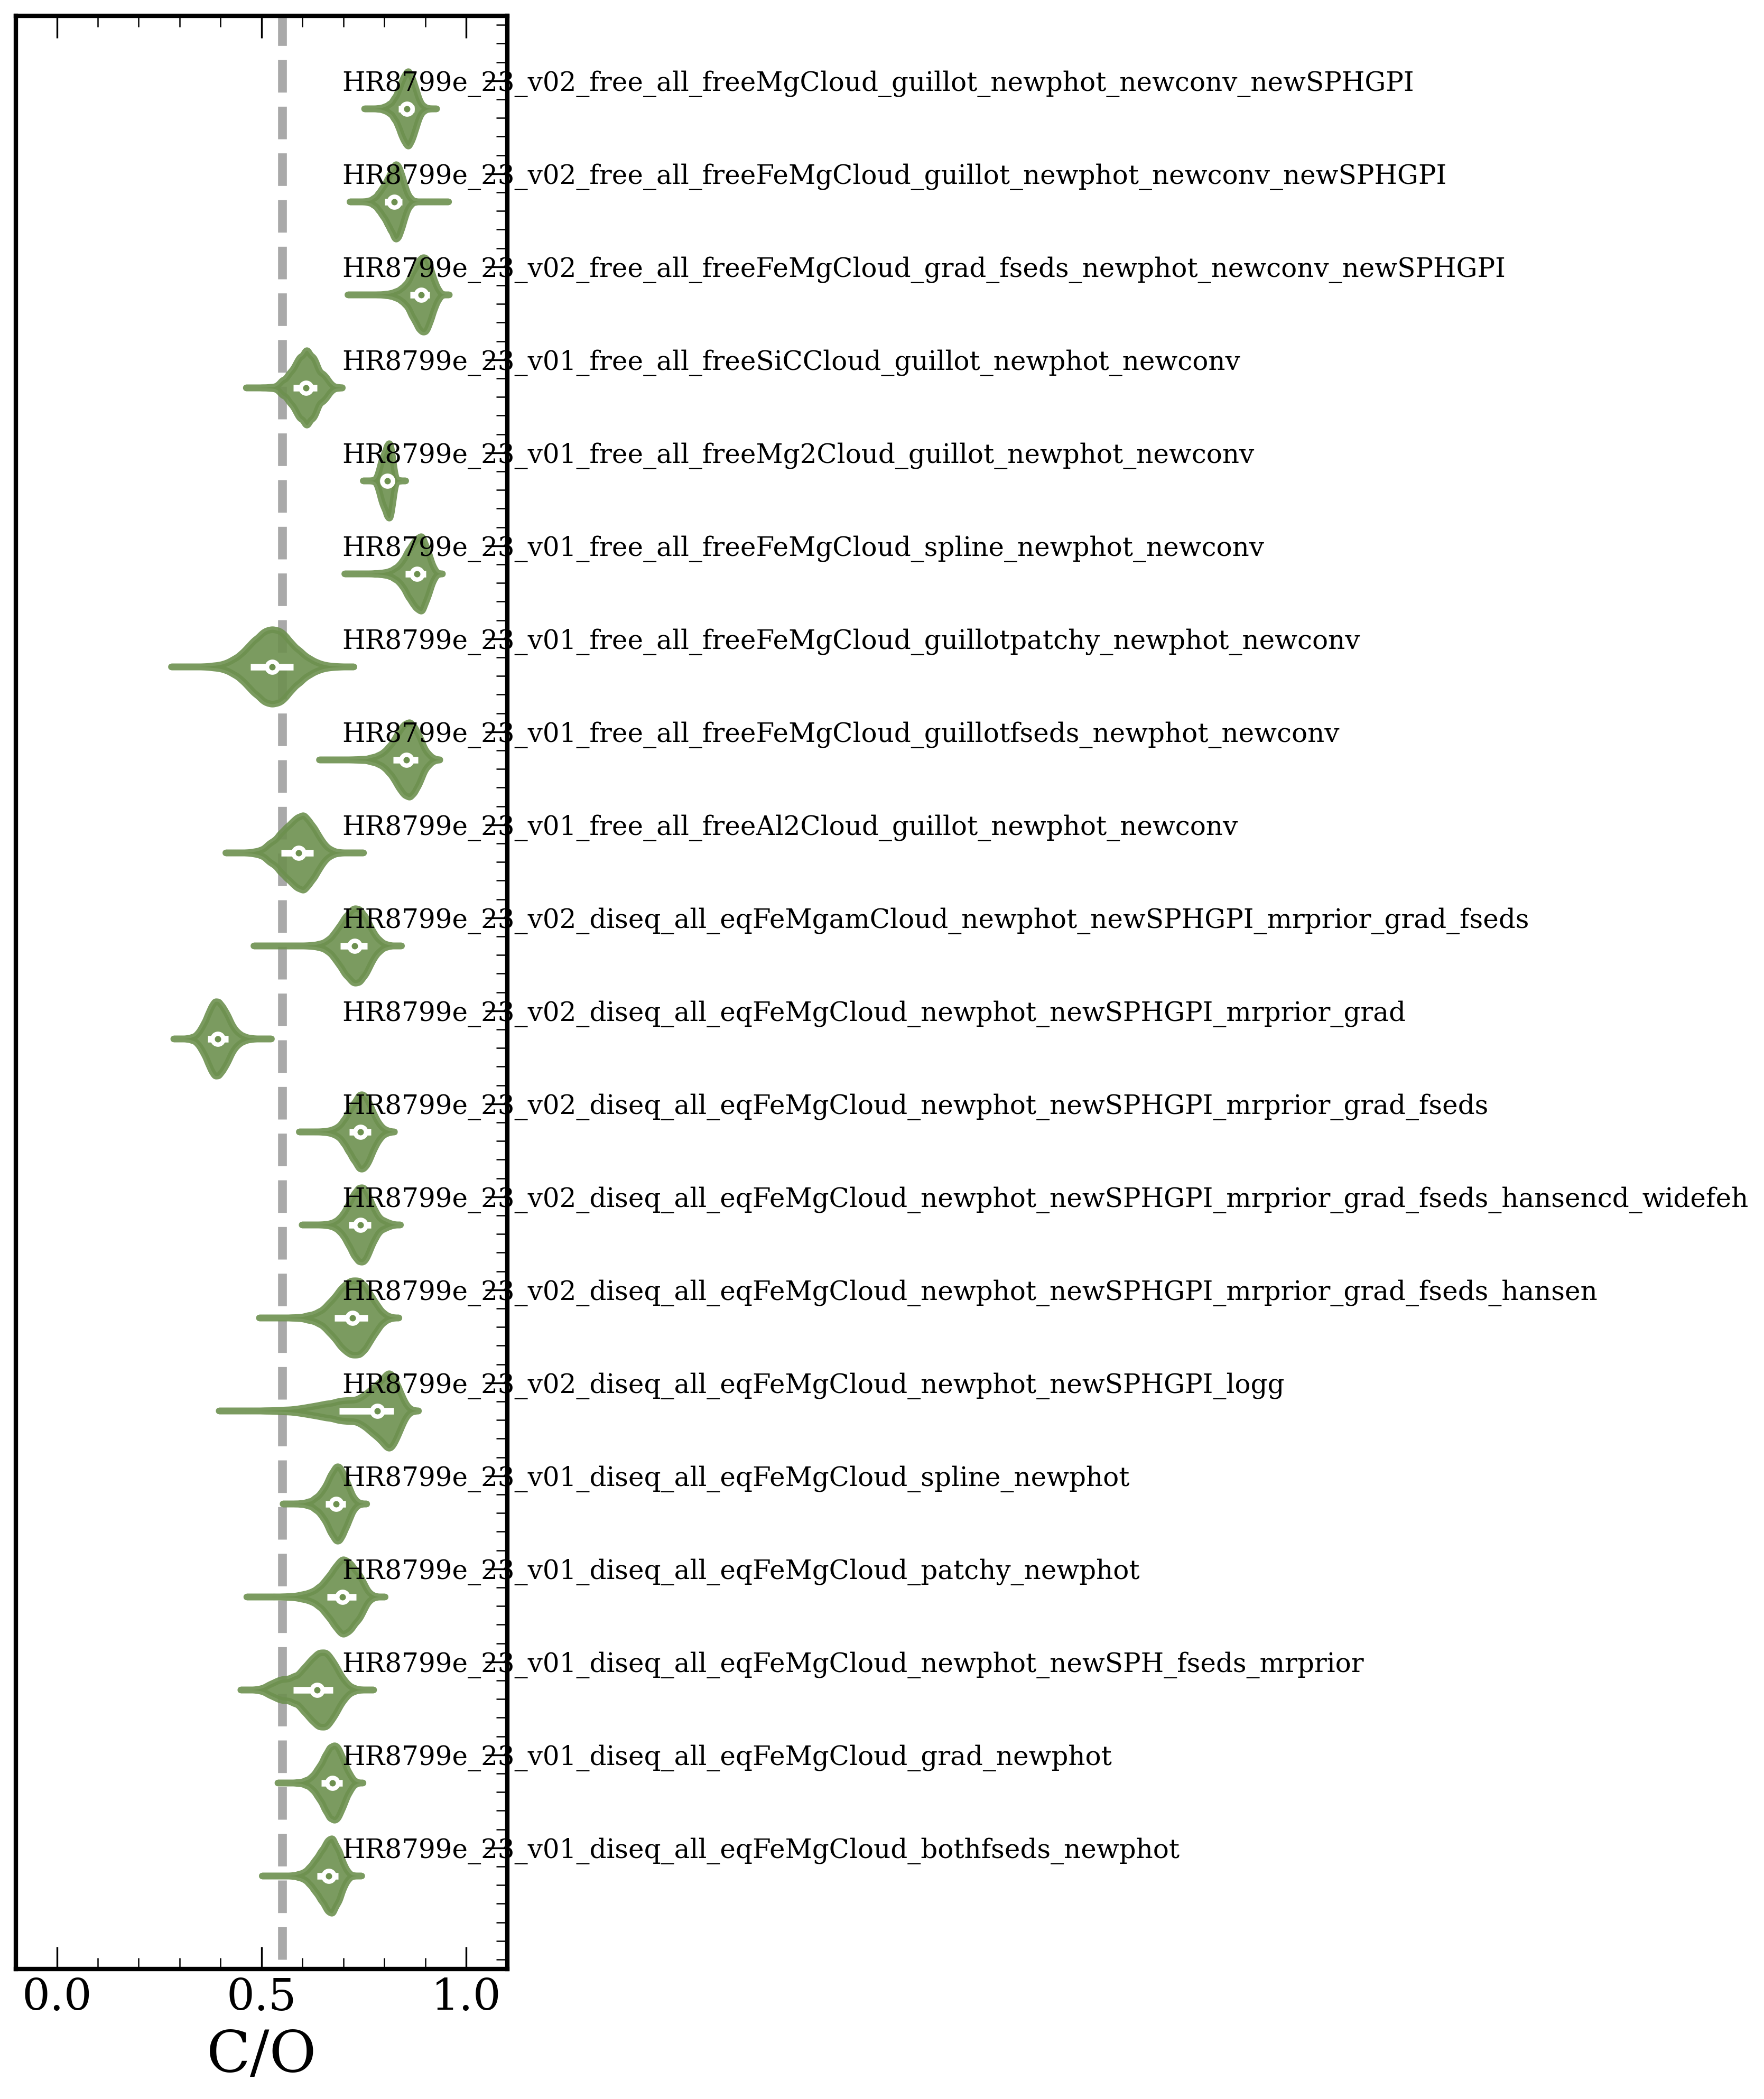

In [ ]:
#snames_temp = []
#for i,ret in enumerate(retrievals_d):
#    snames_temp.append(f"Model {i}")
make_violin_plot(samples,
                 groupB_e, 
                 "C/O", 
                 labels =None,
                 planet = "b",
                 normalize = 1,
                 vline = 0.55,
                 tag = "GroupB")
"""
make_violin_plot(samples,
                 retrievals_d, 
                 "R_pl", 
                 #labels = snames_temp,
                 planet = "d",
                 normalize = nc.r_jup_mean,
                 vline = 1)"""

In [119]:

def calculate_kzz_from_pquench(sample):
    try:
        temperature = sample["Teff"]
    except KeyError:
        return
    gravity = 10**sample["log_g"]
    MMW = sample["MMW"]
    try:
        metallicity = 10**sample["Fe/H"]
    except KeyError:
        return
    try:
        Pquench = 10**sample["log_pquench"]
    except KeyError:
        return
    try:
        Tquench = sample["Teff"]
    except:
        return
    tCO = 1 / ((1/timescale_1(Pquench, metallicity, Tquench)) + (1/timescale_2(Pquench, Tquench)))
    H = scale_height(temperature, MMW, gravity)
    kzz = (H**2)/tCO
    sample["log10_kzz_chem"] = np.log10(kzz)
    return np.log10(kzz)


for key,value in samples.items():
    calculate_kzz_from_pquench(value)

In [125]:
#print(groupA_b)
samples['HR8799b_23_v04_diseq_all_scaleos_eqMgamFeCloud_mrprior_highfeh_fseds']["log_pquench"]

0       -1.447247
1       -1.631401
2       -1.407855
3       -1.439119
4       -1.715203
           ...   
48398   -1.817351
48399   -1.796191
48400   -1.776453
48401   -1.774389
48402   -1.832115
Name: log_pquench, Length: 48403, dtype: float64

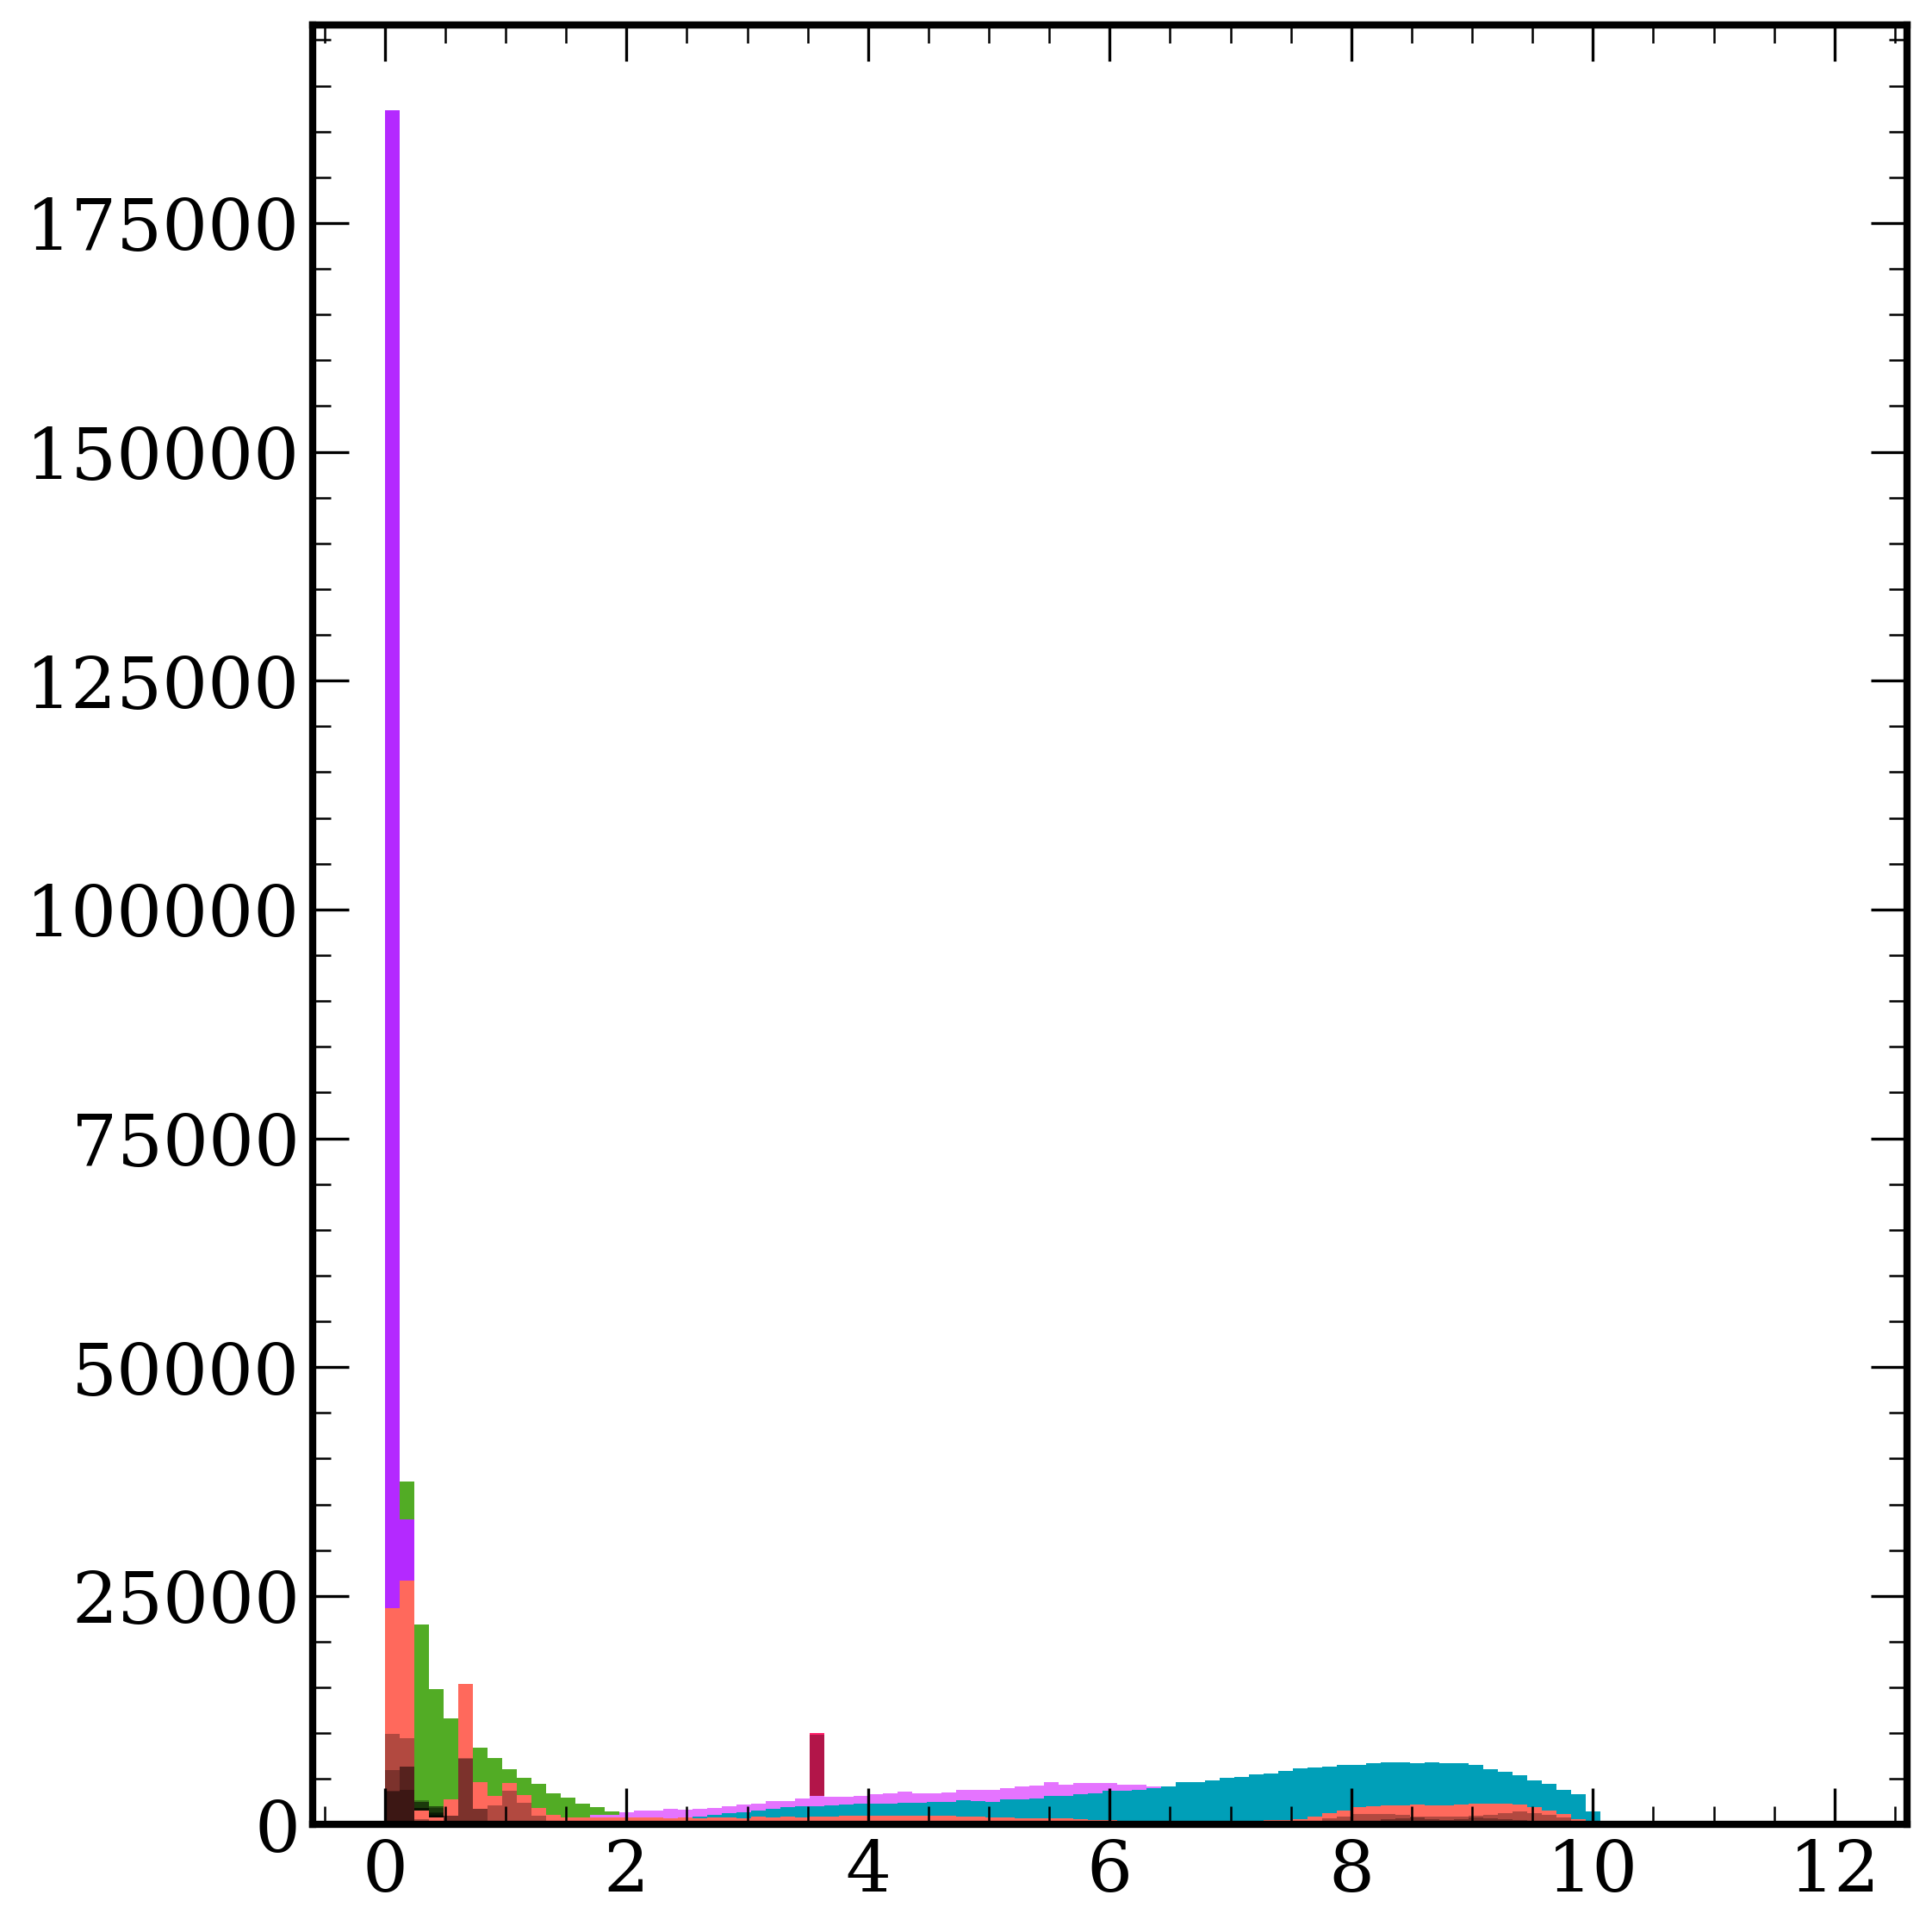

In [157]:
distributions = {"e":groupAB_e,
                 "d":groupAB_d,
                 "c":groupAB_c,
                 "b":groupAB_b}
num_distr = 0
max_evidences_checked = {}
for key,val in distributions.items():
    max_evidences_checked[key] = -np.inf
    if len(val)>num_distr:
        num_distr = len(val)
    for item in val:
        #if "free" in item:continue
        try:
            if samples[item].log10_baysian_evidence > max_evidences_checked[key]:
                max_evidences_checked[key] = samples[item].log10_baysian_evidence
        except: pass

fig, ax = plt.subplots(figsize = (8,8))

#hist_params = ["Fe/H", "C/O", "R_pl", "log_g", "Teff", "mass"]
#hist_params = ["log10_kzz_chem","log_kzz","log_pquench"]
hist_params = ["fsed_MgSiO3(c)","fsed_Fe(c)","fsed"]
param_borders = {}
param_borders["Fe/H"] = (-0.2,2.76)
param_borders["C/O"] = (-0.1,1.1)
param_borders["R_pl"] = (0.78,1.42)
param_borders["log_g"] = (2.8,5.2)
param_borders["Teff"] = (680,1510)
param_borders["mass"] = (3.8,12.2)
param_borders["log_kzz"] = (-2,15)
param_borders["log10_kzz_chem"] = (-2,15)
param_borders["log_pquench"] = (-5,3)
param_borders["fsed_MgSiO3(c)"] = (0,12)
param_borders["fsed_Fe(c)"] = (0,12)
param_borders["fsed"] = (0,12)
sample_size = 10000 
data = np.zeros((sample_size, num_distr, len(hist_params),len(planets)))
rands = np.zeros((sample_size, num_distr, len(hist_params),len(planets)))
bin_dict = {}
count_dict = {}
bayes_factors = {}
for iplan,planet in enumerate(planets):
    bin_dict[planet] = {}
    count_dict[planet] = {}
    bayes_factors[planet] = {}
    ndist = len(distributions[planet])

    for ipar,param in enumerate(hist_params):
        #if param = "Teff":
        #    sample_size = 2000
        for idx, distr in enumerate(distributions[planet]):
            #if "free" in distr:continue
            if not distr in samples.keys():
                continue
            try:
                #print(planet,distr,samples[distr].log10_baysian_evidence,max_evidence[planet])
                bayes_factors[planet][distr] = samples[distr].log10_baysian_evidence - max_evidences_checked[planet]
            except:
                bayes_factors[planet][distr] = -5
            if param not in samples[distr].columns:
                data[:,idx,ipar,iplan] = np.nan*np.ones(sample_size)
                continue
            norm = 1.0
            if param == "R_pl":
                norm = nc.r_jup_mean
            if param == "mass":
                norm = nc.m_jup
            suse = samples[distr][param].to_numpy()
            end_indx = suse[~np.isnan(suse)].shape[0]
            samples_idx = np.random.randint(low = 0, high = end_indx, size = sample_size, dtype = int)
            rands[:,idx,ipar,iplan] = samples_idx
            data[:,idx,ipar,iplan] = suse[~np.isnan(suse)][samples_idx]/norm

        #random_idx = np.random.choice(np.arange(num_distr), size=(sample_size,), p=coefficients)
        #sample = data[np.arange(sample_size), random_idx]
        bins = np.linspace(param_borders[param][0],param_borders[param][1],100)
        n_par, bins_par, patches_par = ax.hist(data[:,:ndist,ipar,iplan].flatten(), bins=bins, density=False)
        bin_dict[planet][param] = bins_par
        count_dict[planet][param] = n_par
        for idx, distr in enumerate(distributions[planet]):
            if not distr in samples.keys():
                continue
            if param not in samples[distr].columns:
                data[:,idx,ipar,iplan] = np.nan*np.ones(sample_size)
                continue
            ax.hist(samples[distr].iloc[rands[:,idx,ipar,iplan]][param], 
                    bins = bin_dict[planet][param], 
                    density = False, 
                    histtype= 'stepfilled', 
                    stacked = False,
                    alpha = 0.3,
                    color = 'k')
#ax.set_yscale('log')


/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/1350286291.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"plots/HR8799_AllPlanet_ChemParams_GROUPA_KDEHists_v6.pdf",bbox_inches = 'tight')
/var/folders/zb/1kks1nb14h7_f6zq97b6sg8xxc6_b4/T/ipykernel_70086/1350286291.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"plots/HR8799_AllPlanet_ChemParams_GROUPA_KDEHists_v6.pdf",bbox_inches = 'tight')
/Users/nasedkin/anaconda3/envs/pRTUpdate/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


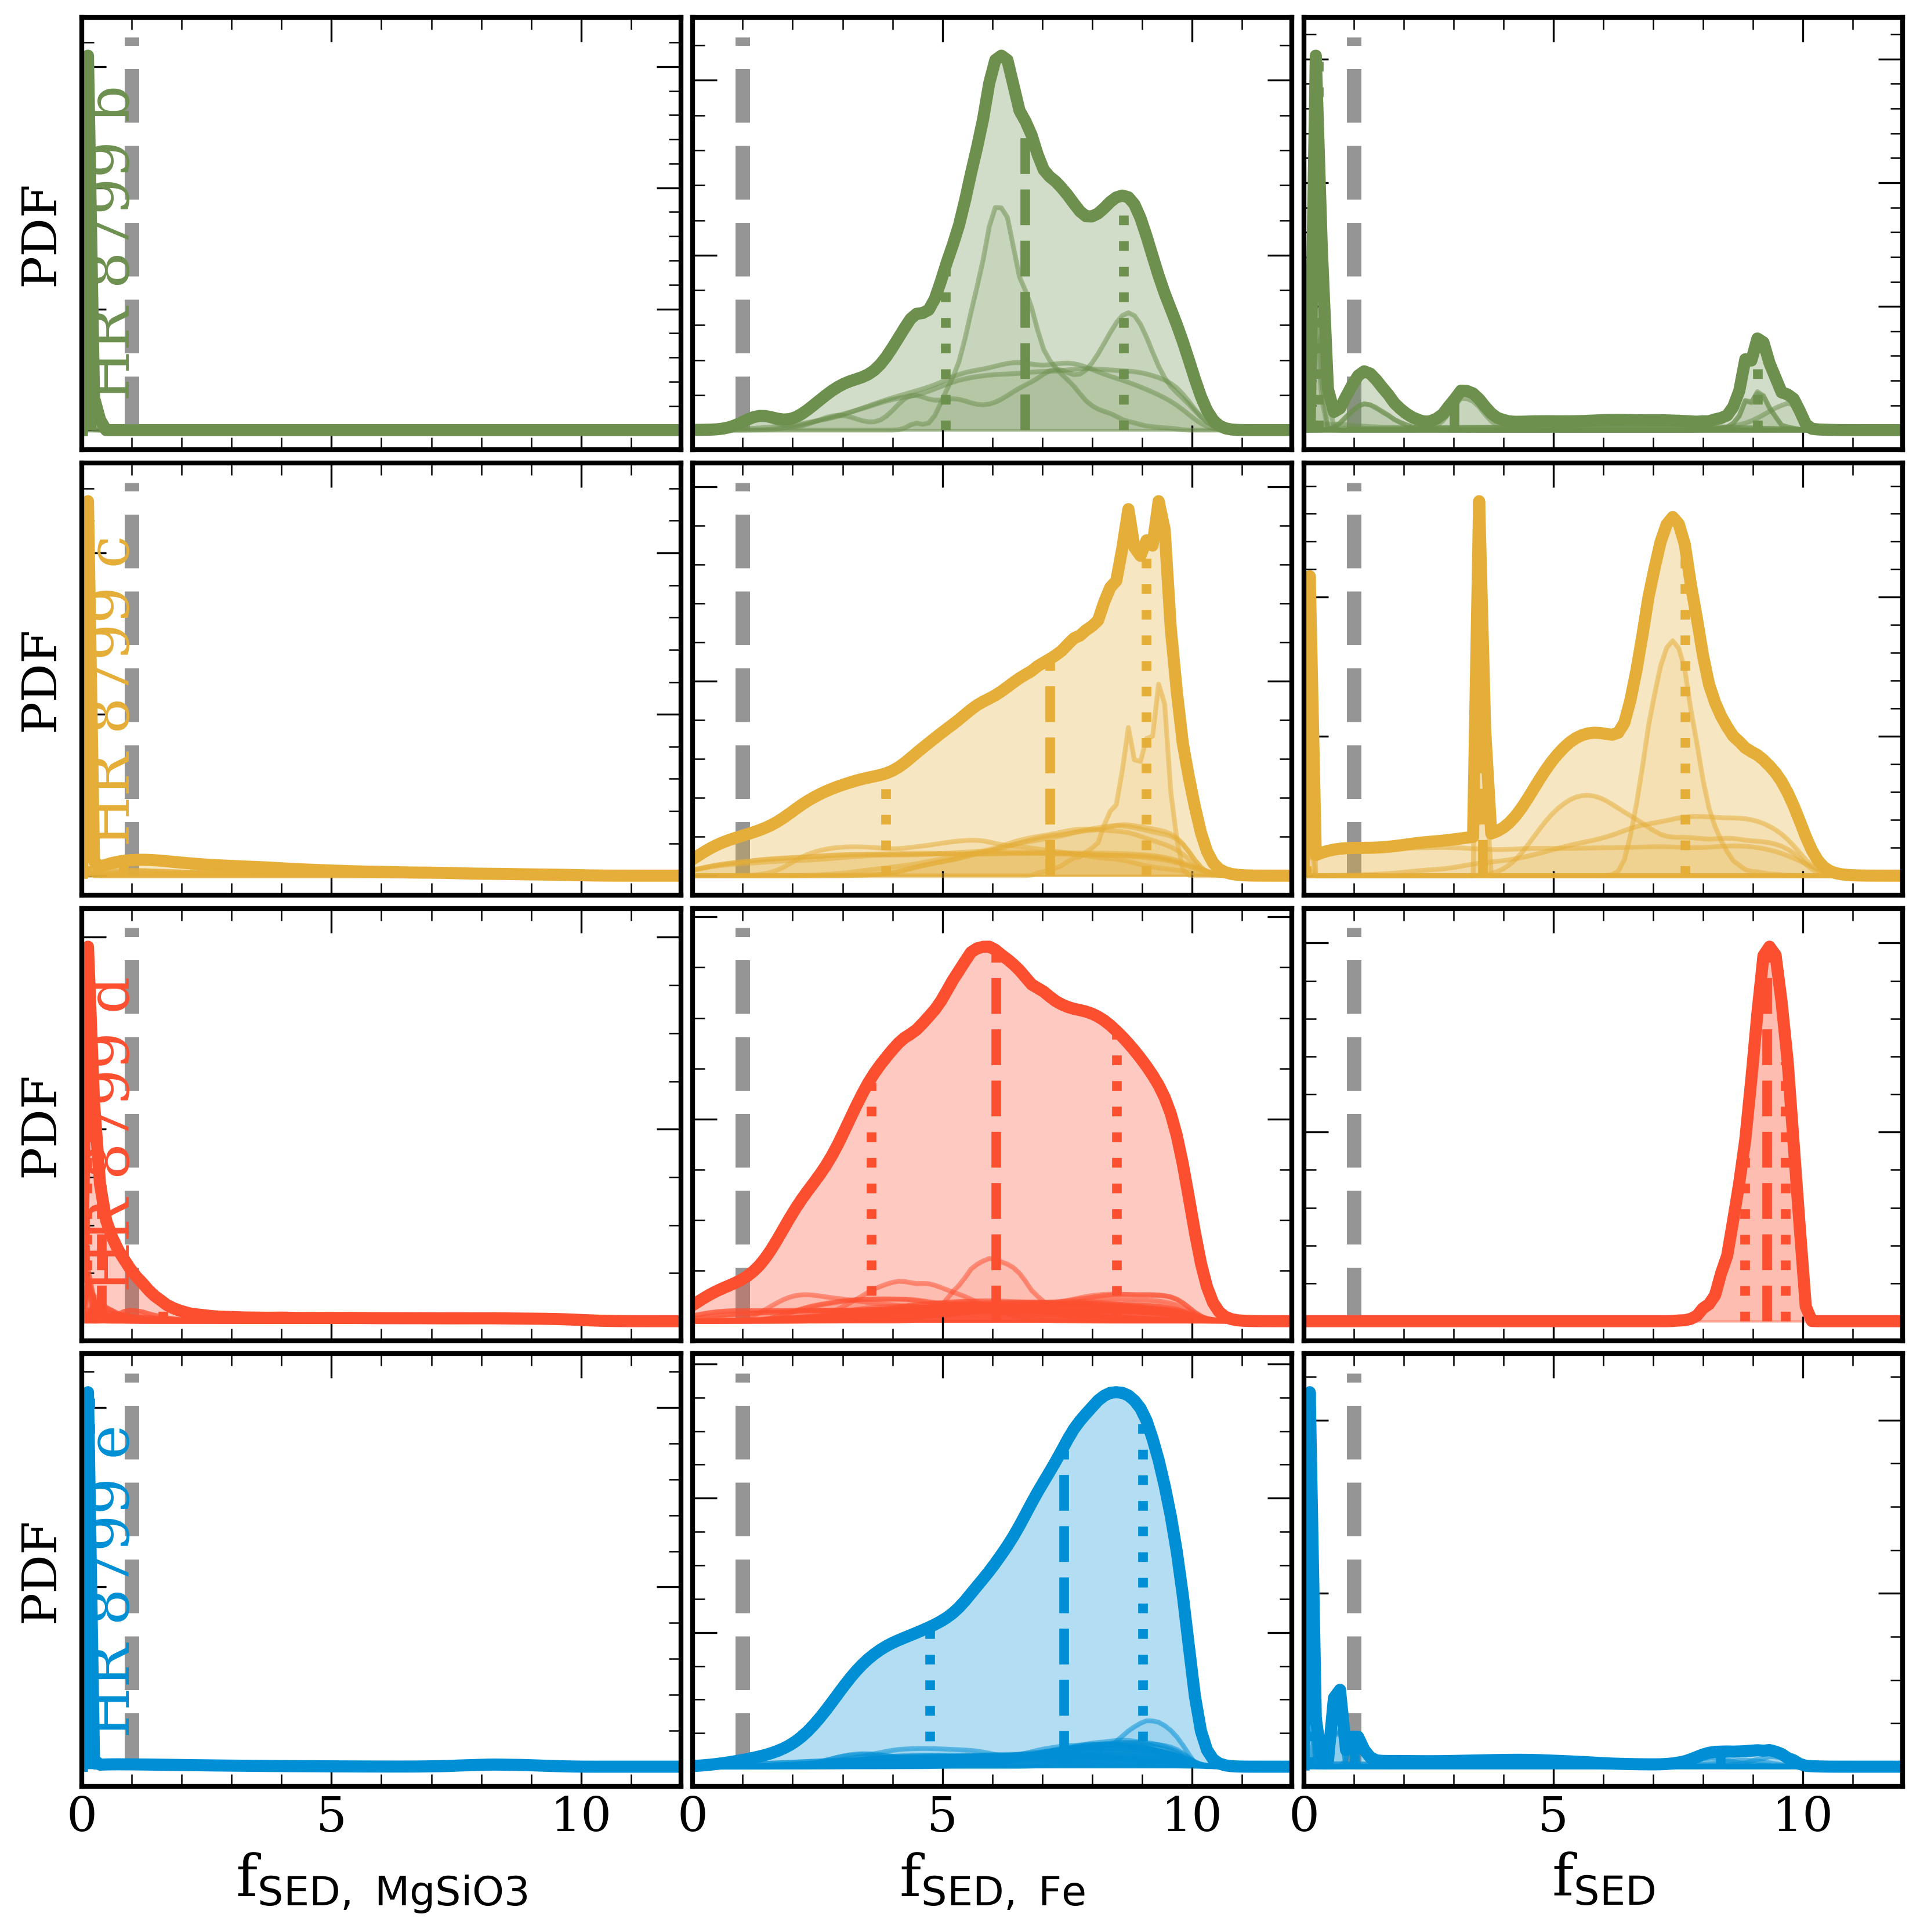

In [158]:
from scipy import stats
fig, ax = plt.subplots(figsize = (4.5*len(hist_params),3.3*len(planets)), 
                       ncols=len(hist_params), 
                       nrows=len(planets),
                       gridspec_kw = {"hspace" : 0.03,"wspace":0.02},
                       sharey=False)

label_dict = {}
label_dict["C/O"] = "C/O"
label_dict["Fe/H"] = "[M/H]"
label_dict["H2O_Exomol"] = "Water Mass Fraction"
label_dict["CO_all_iso_HITEMP"] = "CO Mass Fraction"
label_dict["CH4"] = "CH4"
label_dict["log_g"] = r"$\log g$ [cgs]"
label_dict["R_pl"] = r"Radius [R$_{\rm Jup}$]"
label_dict["mass"] = r"Mass [M$_{\rm Jup}$]"
label_dict["Teff"] = r"T$_{\rm Eff}$ [K]"
label_dict["log_kzz"] = r"$\log K_{\rm ZZ,~cloud}$"
label_dict["log10_kzz_chem"] = r"$\log K_{\rm ZZ,~chem}$"
label_dict["log_pquench"] = r"$\log P_{\rm quench}$"
label_dict["fsed_MgSiO3(c)"] = r"f$_{\rm SED,~MgSiO3}$"
label_dict["fsed_Fe(c)"] = r"f$_{\rm SED,~Fe}$"
label_dict["fsed"] = r"f$_{\rm SED}$"

vline_dict = {}
vline_dict["C/O"] = 0.55
vline_dict["Fe/H"] = 0.0
vline_dict["log_g"] = 4.0
vline_dict["R_pl"] = 1.0
vline_dict["Teff"] = 1200
vline_dict["mass"] = 8
vline_dict["log_kzz"] = 8
vline_dict["log10_kzz_chem"] = 8
vline_dict["log_pquench"] = 0
vline_dict["fsed_MgSiO3(c)"] = 1
vline_dict["fsed_Fe(c)"] = 1
vline_dict["fsed"] = 1
ylims = [(0.0,0.038),(0.0,0.048),(0.0,0.043),(0.0,0.063),(0.0,0.063)]
planet_labels = ["HR 8799 b", "HR 8799 c", "HR 8799 d" , "HR 8799 e"]

total_evidence = {}
model_probability = {}
max_weights = {}
for planet in planets:
    total_evidence[planet] = 0
    model_probability[planet] = 1/len(distributions[planet])
    for distr in distributions[planet]:
        #if "free" in distr:continue
        if distr not in bayes_factors[planet]:
                continue
        total_evidence[planet] += (10**bayes_factors[planet][distr])*model_probability[planet]
fname = "median_weighted_values.txt"
with open(fname, "w+") as myFile:
    for iplan,planet in enumerate(planets):
        for ipar, param in enumerate(hist_params):
            ndist = len(distributions[planet])

            points = data[:,:ndist,ipar,iplan].flatten()
            points = points[~np.isnan(points)]
            weighted_points = []
            cumulative = np.zeros_like(bin_dict[planet][param])
            if len(points)==0:
                continue
            q1, m, q3 = np.quantile(points, [0.159, 0.50, 0.841])
            q1idx = (np.abs(bin_dict[planet][param] - q1)).argmin()
            midx = (np.abs(bin_dict[planet][param] - m)).argmin()
            q3idx = (np.abs(bin_dict[planet][param] - q3)).argmin()

            #kde = stats.gaussian_kde(points)
            #kde_eval = kde(bin_dict[planet][param])/np.sum(kde(bin_dict[planet][param]))
            #points_sum = np.sum(kde(bin_dict[planet][param]))

            #ax[iplan,ipar].hist(points, bins = bin_dict[planet][param], color = colour_dict[planet], density = False)
            #ax[iplan,ipar].plot(bin_dict[planet][param],kde_eval, linewidth = 5, color = colour_dict[planet])
            #ax[iplan,ipar].fill_between(bin_dict[planet][param],kde_eval, alpha = 0.3, color = colour_dict[planet])

            #q1, m, q3 = np.quantile(points, [0.159, 0.50, 0.841])
            #q1idx = (np.abs(bin_dict[planet][param] - q1)).argmin()
            #midx = (np.abs(bin_dict[planet][param] - m)).argmin()
            #q3idx = (np.abs(bin_dict[planet][param] - q3)).argmin()

            #ax[iplan,ipar].vlines(q1,ymin=1e-6,ymax=kde_eval[q1idx], linewidth = 4, linestyle = ':', color = colour_dict[planet])
            #ax[iplan,ipar].vlines(m,ymin=1e-6,ymax=kde_eval[midx], linewidth = 4, linestyle = '--', color = colour_dict[planet])
            #ax[iplan,ipar].vlines(q3,ymin=1e-6,ymax=kde_eval[q3idx], linewidth = 4, linestyle = ':', color = colour_dict[planet])

            for idx, distr in enumerate(distributions[planet]):
                #if "free" in distr:continue
                if distr not in bayes_factors[planet]:
                    continue
                weight = (10**(bayes_factors[planet][distr])*model_probability[planet])/total_evidence[planet]
                weight = 1
                points_c = data[:,idx,ipar,iplan].flatten()
                points_c = points_c[~np.isnan(points_c)]
                points_c = points_c[np.where(points_c!=np.inf)]
                points_c = points_c[np.where(points_c!=-np.inf)]
                #if (np.sum(points_c) < 0): continue
                if len(points_c) < 2: continue
                
                kde_c = stats.gaussian_kde(points_c)
                ax[iplan,ipar].plot(bin_dict[planet][param],
                            kde_c(bin_dict[planet][param])*weight,
                            alpha = 0.5, 
                            linewidth = 2, 
                            color = colour_dict[planet]) 
                ax[iplan,ipar].fill_between(bin_dict[planet][param],
                                    kde_c(bin_dict[planet][param])*weight,
                                    alpha = 0.1, 
                                    color = colour_dict[planet]) 
                cumulative += kde_c(bin_dict[planet][param])*weight
                rints_weight = np.random.randint(low=0,
                                                high = points_c.shape[0]-1,
                                                size = int(points_c.shape[0]*weight))

                weighted_points.extend(points_c[rints_weight])
            #ax[iplan,ipar].set_yscale('log')
            #ax[iplan,ipar].set_ylim(ylims[iplan])
            ax[-1,ipar].set_xlabel(label_dict[param], fontsize = 24)
            ax[iplan,ipar].set_xlim(param_borders[param])
            ax[iplan,0].set_ylabel(f"PDF", fontsize = 20)
            ax[iplan,ipar].set_yticklabels([])
            if iplan != 3:
                ax[iplan,ipar].set_xticklabels([])

            #kde = stats.gaussian_kde(points)
            #kde_eval = kde(bin_dict[planet][param])/np.sum(kde(bin_dict[planet][param]))
            #points_sum = np.sum(kde(bin_dict[planet][param]))

            #ax[iplan,ipar].hist(points, bins = bin_dict[planet][param], color = colour_dict[planet], density = False)
            ax[iplan,ipar].plot(bin_dict[planet][param],cumulative, linewidth = 5, color = colour_dict[planet])
            ax[iplan,ipar].fill_between(bin_dict[planet][param],cumulative, alpha = 0.3, color = colour_dict[planet])

            weighted_points = np.array(weighted_points)
            if weighted_points.shape[0] < 1:
                continue
            q1, m, q3 = np.quantile(weighted_points, [0.159, 0.50, 0.841])
            q1idx = (np.abs(bin_dict[planet][param] - q1)).argmin()
            midx = (np.abs(bin_dict[planet][param] - m)).argmin()
            q3idx = (np.abs(bin_dict[planet][param] - q3)).argmin()
            myFile.write(f"{planet}, {param}, {m:.2f}^{{+{q3-m:.2f}}}_{{-{m-q1:.2f}}}\n")


            vline = vline_dict[param]
            if param == "Teff" and "b" in planet:
                vline = 950
            if param == "mass" and "b" in planet:
                vline = 5.8
            if param == "mass" and "c" in planet:
                vline = 7.7
            if param == "mass" and "d" in planet:
                vline = 9.2
            if param == "mass" and "e" in planet:
                vline = 7.7
            if param == "C/O" and "d" in planet:
                percentiles = np.percentile(weighted_points,[90,95,99,99.9])
                print(percentiles)
            ylimdown,ylimup = ax[iplan,ipar].axes.get_ylim()
            ax[iplan,ipar].vlines(q1,ymin=1e-6,ymax=cumulative[q1idx], linewidth = 4, linestyle = ':', color = colour_dict[planet])
            ax[iplan,ipar].vlines(m,ymin=1e-6,ymax=cumulative[midx], linewidth = 4, linestyle = '--', color = colour_dict[planet])
            ax[iplan,ipar].vlines(q3,ymin=1e-6,ymax=cumulative[q3idx], linewidth = 4, linestyle = ':', color = colour_dict[planet])
            ax[iplan,ipar].vlines(vline,ymin=1e-6,ymax=ylimup, linewidth = 6, linestyle = '--', color = 'dimgray', zorder = 0, alpha = 0.7)
        ax[iplan,0].annotate(planet_labels[iplan], 
                            (0.08,0.1*ax[iplan,0].get_ylim()[1]), 
                            color = colour_dict[planet],
                            fontsize = 24,
                            rotation = 90)
fig.align_ylabels()
plt.savefig(f"plots/HR8799_AllPlanet_ChemParams_GROUPA_KDEHists_v6.pdf",bbox_inches = 'tight')

In [162]:
parameters_use = ["Teff", "log_g", "Fe/H", "C/O", "R_pl", "Lbol", "mass"]

bA_evs_sort = np.argsort(np.array([samples[ret].log10_baysian_evidence for ret in groupA_b]))[::-1]
b_list = [groupA_b[i] for i in bA_evs_sort]
bB_evs_sort = np.argsort(np.array([samples[ret].log10_baysian_evidence for ret in groupB_b]))[::-1]
bB = []
for i in bB_evs_sort:
    if not groupB_b[i] in groupA_b and groupB_b[i] in samples.keys():
        bB.append(groupB_b[i])
b_list += bB
groupC_b = []
for ret in retrievals_b:
    if ret not in groupA_b and ret not in bB and ret not in failed_retrievals and ret in samples.keys():
        groupC_b.append(ret)
bC_evs_sort = np.argsort(np.array([samples[ret].log10_baysian_evidence for ret in groupC_b]))[::-1]
b_list += [groupC_b[i] for i in bC_evs_sort]


cA_evs_sort = np.argsort(np.array([samples[ret].log10_baysian_evidence for ret in groupA_c]))[::-1]
c_list = [groupA_c[i] for i in cA_evs_sort]
cB_evs_sort = np.argsort(np.array([samples[ret].log10_baysian_evidence for ret in groupB_c]))[::-1]
cB = []
for i in cB_evs_sort:
    if not groupB_c[i] in groupA_c:
        cB.append(groupB_c[i])
c_list += cB

groupC_c = []
for ret in retrievals_c:
    if ret not in groupA_c and ret not in cB and ret not in failed_retrievals and ret in samples.keys():
        groupC_c.append(ret)
cC_evs_sort = np.argsort(np.array([samples[ret].log10_baysian_evidence for ret in groupC_c]))[::-1]
c_list += [groupC_c[i] for i in cC_evs_sort]

dA_evs_sort = np.argsort(np.array([samples[ret].log10_baysian_evidence for ret in groupA_d]))[::-1]
d_list = [groupA_d[i] for i in dA_evs_sort]
dB_evs_sort = np.argsort(np.array([samples[ret].log10_baysian_evidence for ret in groupB_d]))[::-1]
dB = []
for i in dB_evs_sort:
    if not groupB_d[i] in groupA_d:
        dB.append(groupB_d[i])
d_list += dB

groupC_d = []
for ret in retrievals_d:
    if ret not in groupA_d and ret not in dB and ret not in failed_retrievals and ret in samples.keys():
        groupC_d.append(ret)
dC_evs_sort = np.argsort(np.array([samples[ret].log10_baysian_evidence for ret in groupC_d]))[::-1]
d_list += [groupC_d[i] for i in dC_evs_sort]


eA_evs_sort = np.argsort(np.array([samples[ret].log10_baysian_evidence for ret in groupA_e]))[::-1]
e_list = [groupA_e[i] for i in eA_evs_sort]
eB_evs_sort = np.argsort(np.array([samples[ret].log10_baysian_evidence for ret in groupB_e]))[::-1]
eB = []
for i in eB_evs_sort:
    if not groupB_e[i] in groupA_e:
        eB.append(groupB_e[i])
e_list += eB
groupC_e = []
for ret in retrievals_e:
    if ret not in groupA_e and ret not in eB and ret not in failed_retrievals and ret in samples.keys():
        groupC_e.append(ret)
eC_evs_sort = np.argsort(np.array([samples[ret].log10_baysian_evidence for ret in groupC_e]))[::-1]
e_list += [groupC_e[i] for i in eC_evs_sort]

groupA_all = groupA_b
groupA_all.extend(groupA_c)
groupA_all.extend(groupA_d)
groupA_all.extend(groupA_e)

groupB_all = groupB_b
groupB_all.extend(groupB_c)
groupB_all.extend(groupB_d)
groupB_all.extend(groupB_e)

print(len(retrievals_e),len(e_list))


49 42


In [ ]:
def write_latex_table(samples, retrievals_use, short_names, parameters_use):
    output_filename = "HR8799_retrieval_summary_table_latex.tex"

    label_dict = {}
    label_dict["C/O"] = "\\textbf{C/O}"
    label_dict["Fe/H"] = "\\textbf{[M/H]}"
    label_dict["H2O_Exomol"] = "\\textbf{Water Mass Fraction}"
    label_dict["CO_all_iso_HITEMP"] = "\\textbf{CO Mass Fraction}"
    label_dict["CH4"] = "CH4"
    label_dict["log_g"] = "$\\bm{\\log g}$"
    label_dict["R_pl"] = "\\textbf{Radius}"
    label_dict["mass"] = "\\textbf{Mass}"
    label_dict["Teff"] = "$\\mathbf{T_{\\rm Eff}}$"
    label_dict["fsed"] = "$\\mathbf{f_{\\rm SED}}$"
    label_dict["Lbol"] = "$\\bm{\\log L/L_{\\odot}}$"

    unit_dict = {}
    unit_dict["C/O"] = ""
    unit_dict["Fe/H"] = ""
    unit_dict["H2O_Exomol"] = ""
    unit_dict["CO_all_iso_HITEMP"] = ""
    unit_dict["CH4"] = ""
    unit_dict["log_g"] = "[cgs]"
    unit_dict["R_pl"] = "[R$_{\\rm Jup}$]"
    unit_dict["mass"] = "[M$_{\\rm Jup}$]"
    unit_dict["Teff"] = "[K]"
    unit_dict["fsed"] = ""
    unit_dict["Lbol"] = ""
    
    header = "\\textbf{Planet} & \\textbf{Index} & \\textbf{Model} & $\\bm{\\Delta\\log}_{\\mathbf{10}} \\bm{\\mathcal{Z}}$ & $\\bm{\\chi^{2}/\\nu}$ "
    for parameter in parameters_use:
        header += f"& {label_dict[parameter]} "
    units = f" &  &  &  & "
    for parameter in parameters_use:
        units += f"& {unit_dict[parameter]} "
    with open(output_filename,'w+') as myFile:
        for iplan,planet in enumerate(planets):
            count = 0
            #myFile.write("\\begin{landscape}\n")
            myFile.write("\\begin{sidewaystable*}[t]\n")
            myFile.write("\\centering\n")
            myFile.write("\\begin{threeparttable}\n")
            myFile.write("\\centering\n")
            myFile.write("\\begin{small}\n")
            myFile.write(f"\\caption{{Abridged retrieval results HR 8799 {planet}}}\n")
            myFile.write(f"\\label{{tab:full_results_{planet}}}\n")
            myFile.write("\\begin{tabular}{lll|lllllllll}\n")
            myFile.write("\\toprule\n")
            myFile.write(header)
            myFile.write("\\\\\n")
            myFile.write(units)
            myFile.write("\\\\\n")
            myFile.write("\\midrule\n")
            myFile.write(f"{planet} &")
            for iret, ret in enumerate(retrievals_use[planet]):
                model_short = ""
                if "diseq" in ret:
                    model_short += "D/"
                else:
                    model_short+= "F/"
                text_params = list(samples[ret].columns)
                if "log_delta" in text_params:
                    model_short += "M/"
                elif "T_bottom" in text_params:
                    model_short += "Z/"
                elif "log_kappa_IR" in text_params:
                    model_short += "G/"
                else:
                    model_short += "S"
                    if not "nodes" in ret:
                        nnodes = "4"
                    else:
                        nnodes = ret.split("nodes")[0].split("_")[-1]
                    model_short += nnodes + "/"
                if "eq_scaling_Fe(c)" in text_params or\
                    "eq_scaling_MgSiO3(c)" in text_params or\
                    "eq_scaling_Mg2SiO4(c)" in text_params or\
                    "eq_scaling_KCL(c)" in text_params or\
                    "eq_scaling_Na2S(c)" in text_params:
                    model_short += "eq"
                elif not "clear" in ret:
                    model_short +="f"
                if "fsed_Fe(c)" in text_params:
                    model_short += "*"
                if "eq_scaling_Fe(c)" in text_params or "log_X_cb_Fe(c)" in text_params:
                    model_short += "Fe"
                if "Mgam" in ret:
                    model_short += "Mg_am"
                elif "eq_scaling_MgSiO3(c)" in text_params or "log_X_cb_MgSiO3(c)" in text_params:
                    model_short += "Mg_cd"
                if "eq_scaling_Mg2SiO4(c)" in text_params or "log_X_cb_Mg2SiO4(c)" in text_params:
                    model_short += "Mg2"
                if "eq_scaling_Na2S(c)" in text_params or "log_X_cb_Na2S(c)" in text_params:
                    model_short += "Na"
                if "eq_scaling_KCL(c)" in text_params or "log_X_cb_KCL(c)" in text_params:
                    model_short += "KCL"
                if "eq_scaling_SiO2-Lx(c)" in text_params or "log_X_cb_SiO2-Lx((c)" in text_params:
                    model_short += "SiO2"
                if "al2cloud" in ret.lower():
                    model_short += "Al"
                if "clear" in ret:
                    model_short += "CLR"
                if "patch" in ret:
                    model_short +="_P"
                model_short +="/"
                ALL= True
                if "nograv" in ret.lower():
                    model_short += "-Gr"
                    ALL = False
                elif "onlygrav" in ret:
                    model_short+="Gr"
                    ALL = False
                if "nosph" in ret.lower():
                    model_short += "-S"
                    ALL = False
                if "nogpi" in ret.lower():
                    model_short += "-G"
                    ALL = False
                if "nocharis" in ret.lower():
                    model_short += "-C"
                    ALL = False
                if "noales" in ret.lower():
                    model_short += "-A"
                    ALL = False
                if "nophot" in ret.lower():
                    model_short += "-P"
                    ALL = False
                if ALL:
                    model_short += "ALL"
                model_short +="/"

                if "noh2o" in ret.lower():
                    model_short += "-H2O/"
                if "noh2s" in ret.lower():
                    model_short += "-H2S/"
                if "noch4" in ret.lower():
                    model_short += "-CH4/"
                if "nonh3" in ret.lower():
                    model_short += "-NH4/"
                if "fixedfeh" in ret:
                    model_short+=f"Fe-H{ret.split('fixedfeh')[-1]}"
                if "mr" in ret:
                    model_short += "mr"
                if ret in samples.keys():
                    if samples[ret]['mass'].median()<100:
                        continue
                    if iret!=0:
                        myFile.write(f"  &")
                    group = ""
                    if ret in groupA_all:
                        group = "A"
                    elif ret in groupB_all:
                        group = "B"
                    else:
                        group = "C"
                    myFile.write(f" {group}.{count} &")
                    myFile.write(f" {model_short} &")

                    try: 
                        myFile.write(f" {int(samples[ret].log10_baysian_evidence - max_evidence[planet])} &")
                    except:
                        myFile.write(f" \\ldots &")
                    try:
                        myFile.write(f" {samples[ret].chi2_DoF:.2f} &")
                    except:
                        myFile.write(f" \\ldots &")
                        
                    for ipar,param in enumerate(parameters_use):
                        end = " & "
                        if ipar == (len(parameters_use)-1):
                            end = " \\\\[2pt]\n"
                        if param == "Profile":
                            try:
                                myFile.write(f" {samples[ret].temperature_profile} {end}")
                            except:
                                myFile.write(f" \\ldots {end}")
                    
                        if param in samples[ret].columns:
                            par_array = samples[ret][param].to_numpy()
                            nans = np.isnan(par_array)
                            med = np.quantile(par_array[~nans], q = 0.50)
                            low = med - np.quantile(par_array[~nans], q = 0.159)
                            high = np.quantile(par_array[~nans], q = 0.841)-med

                            norm = 1
                            if param == 'R_pl':
                                norm = nc.r_jup_mean
                                med/=norm
                                low/=norm
                                high/=norm
                            if param == 'mass':
                                norm = nc.m_jup
                                med/=norm
                                low/=norm
                                high/=norm
                            if param == "Teff":
                                myFile.write(f"${int(med)}_{{-{int(low)}}}^{{+{int(high)}}}${end}")
                                continue
                            if med - low < (par_array[~nans].min()/norm):
                                myFile.write(f"$<{med:.2g}${end}")
                            elif med + high > (par_array[~nans].max()/norm):
                                myFile.write(f"$>{med:.2g}${end}")
                            
                            if low < 0.1:
                                myFile.write(f"${round(med,2)}_{{-{low:.1g}}}^{{+{high:.1g}}}${end}")
                                continue
                            if high>=9:
                                myFile.write(f"${med:.2f}_{{-{int(low)}}}^{{+{int(high)}}}${end}")
                                continue
                            myFile.write(f"${med:.2g}_{{-{low:.1g}}}^{{+{high:.1g}}}${end}")
                        else: 
                            myFile.write(f"\\ldots{end}")
                    count += 1
            myFile.write("\\bottomrule\n")
            myFile.write("\\end{tabular}\n")
            myFile.write("\\end{small}\n")
            myFile.write("\\begin{tablenotes}\n")
            myFile.write("\\small\n")
            myFile.write("\\item\\textbf{Notes}\n")
            myFile.write("\\item All values presented are the median values from the fits, with uncertainties given as the $\pm 34.1$\% percentiles.\n")
            myFile.write("\\end{tablenotes}\n")
            myFile.write("\\end{threeparttable}\n")
            myFile.write("\\end{sidewaystable*}\n")
            #myFile.write("\\end{landscape}\n")

In [ ]:
distributions = {"b":b_list,
                 "c":c_list,
                 "d":d_list,
                 "e":e_list}
write_latex_table(samples, distributions, {}, parameters_use)



In [ ]:
parameters_use_long =  ["R_pl", 
                        "mass",
                        "log_g", 
                        "Profile",
                        "Fe/H",
                        "C/O", 
                        "log_pquench", 
                        "H2O_Exomol", 
                        "CO_all_iso_HITEMP",
                        "sigma_lnorm",
                        "b_hans",
                        "log_kzz",
                        "fsed",
                        "fsed_MgSiO3(c)",
                        "fsed_Fe(c)",
                        "log_X_cb_MgSiO3(c)",
                        "log_X_cb_Fe(c)",
                        "log_Pbase_MgSiO3(c)",
                        "log_PBase_Fe(c)"
                        ]



In [159]:
groupAB_sorted_b = []
count = 0
snames = {}
for item in b_list: 
    name = ""
    if item in groupA_b:
        name = f"b.A.{count}"
        groupAB_sorted_b.append(item)
    elif item in groupB_b:
        name = f"b.B.{count}"
        groupAB_sorted_b.append(item)
    else:
        name = f"b.C.{count}"
    snames[item] = name
    count +=1

groupAB_sorted_c = []
count = 0
for item in c_list: 
    name = ""
    if item in groupA_c:
        name = f"c.A.{count}"
        groupAB_sorted_c.append(item)
    elif item in groupB_c:
        name = f"c.B.{count}"
        groupAB_sorted_c.append(item)
    else:
        name = f"c.C.{count}"
    snames[item] = name
    count +=1

groupAB_sorted_d = []
count = 0
for item in d_list: 
    name = ""
    if item in groupA_d:
        name = f"d.A.{count}"
        groupAB_sorted_d.append(item)
    elif item in groupB_d:
        name = f"d.B.{count}"
        groupAB_sorted_d.append(item)
    else:
        name = f"d.C.{count}"
    snames[item] = name
    count +=1

groupAB_sorted_e = []
count = 0
for item in e_list: 
    name = ""
    if item in groupA_e:
        name = f"e.A.{count}"
        groupAB_sorted_e.append(item)
    elif item in groupB_e:
        name = f"e.B.{count}"
        groupAB_sorted_e.append(item)
    else:
        name = f"e.C.{count}"
    snames[item] = name
    count +=1

groupAB_sorted_e.reverse()
groupAB_sorted_d.reverse()
groupAB_sorted_c.reverse()
groupAB_sorted_b.reverse()

NameError: name 'b_list' is not defined

In [ ]:
snames


{'HR8799b_23_v02_diseq_all_scaleos_freeFeMgCloud_mrprior_newdata_newphot': 'b.A.0',
 'HR8799b_23_v04_diseq_all_scaleos_eqMgamFeCloud_mrprior_highfeh_fseds': 'b.A.1',
 'HR8799b_23_v01_free_all_correctos_freeMgCloud_1nodes_v5': 'b.A.2',
 'HR8799b_23_v03_free_all_correctos_freeSiO2Cloud_newphotv2_mrprior': 'b.A.3',
 'HR8799b_23_v01_free_all_correctos_freeMgCloud_0nodes_v5': 'b.A.4',
 'HR8799b_23_v01_free_all_correctos_eqMgCloud_0nodes_v6': 'b.A.5',
 'HR8799b_23_v01_free_all_correctos_freeMgCloud_guillot_newphot_mrprior': 'b.A.6',
 'HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_highfeh_fseds': 'b.B.7',
 'HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_highfeh_grad_fseds': 'b.B.8',
 'HR8799b_23_v04_diseq_all_scaleos_eqNa2SCloud_mrprior_highfeh_fseds': 'b.B.9',
 'HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_newdata_newphot': 'b.B.10',
 'HR8799b_23_v02_diseq_all_scaleos_eqNa2SCloud_mrprior_newdata_newphot': 'b.B.11',
 'HR8799b_23_v03_free_all_correctos_freeMgCloud_grad_new

In [36]:
samples["HR8799b_23_v02_diseq_all_scaleos_eqFeMgCloud_mrprior_newdata_newphot"]["log10_kzz_chem"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
46229   NaN
46230   NaN
46231   NaN
46232   NaN
46233   NaN
Name: log10_kzz_chem, Length: 46234, dtype: float64

In [106]:
param = "Fe/H"
vert_ind = 0
norm = 1

make_violin_plot(samples,
                 groupAB_sorted_e, 
                 param, 
                 planet = "e",
                 normalize = norm,
                 vline = vert_ind,
                 tag = "GroupAB",
                 labels = snames)
make_violin_plot(samples,
                 groupAB_sorted_d, 
                 param, 
                 planet = "d",
                 normalize = norm,
                 vline = vert_ind,
                 tag = "GroupAB",
                 labels = snames)
make_violin_plot(samples,
                 groupAB_sorted_c, 
                 param, 
                 planet = "c",
                 normalize = norm,
                 vline = vert_ind,
                 tag = "GroupAB",
                 labels = snames)
make_violin_plot(samples,
                 groupAB_sorted_b, 
                 param, 
                 planet = "b",
                 normalize = norm,
                 vline = vert_ind,
                 tag = "GroupAB",
                 labels = snames)

NameError: name 'groupAB_sorted_e' is not defined

In [169]:
c_list

['HR8799c_23_v04_free_grav_noos_freeFeMgCloud_grad_newphot_newGPI_fseds_mr',
 'HR8799c_23_v01_diseq_all_grav_eqFeMgamPatchyCloud_mr_fseds_newbins_newphot',
 'HR8799c_23_v01_diseq_all_grav_freeFeMgCloud_mr_fseds_newbins_newphot',
 'HR8799c_23_v01_diseq_all_grav_eqFeMgCloud_logg_fseds_newbins_newphot',
 'HR8799c_23_v01_diseq_all_noos_patchyeqFeMgCloud_logg_newbins_newphot',
 'HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud_mrprior',
 'HR8799c_23_v01_diseq_onlygrav_noos_eqMgCloud_logg',
 'HR8799c_23_v03_free_all_onlygrav_nogpi_clear_guillot',
 'HR8799c_23_v04_free_grav_noos_freeFeMgCloud_spline_newphot_newGPI_fseds_mr',
 'HR8799c_23_v03_free_all_onlygrav_nogpi_eqMgCloud_guillot',
 'HR8799c_23_v03_free_all_all_noos_freeFeMgCloud_guillot',
 'HR8799c_23_v03_free_all_all_noos_freeMgCloud_guillot',
 'HR8799c_23_v04_free_grav_noos_freeFeMg2Cloud_guillot_newphot_newGPI_fseds_mr',
 'HR8799c_23_v04_free_grav_noos_freeMgCloud_guillot_newphot_newGPI_fseds_mr',
 'HR8799c_23_v01_diseq_all_noos_eqFeMg

5749.8, 1.83
5748.4, 1.82